<a href="https://colab.research.google.com/github/blainerothrock/nlp-group-2/blob/master/nlp_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 2 (Bengio and other Neural Language Models)

In [1]:
from __future__ import absolute_import, division, print_function

# %tensorflow_version 2.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

# from google.colab import drive, files 
# drive.mount('/content/drive')

import os, pickle
import numpy as np
import math
import typing
import matplotlib.pyplot as plt

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term
2.0.0


In [2]:
blaine_ubuntu_data_path = '../data'
blaine_data_path = '/Users/blaine/Google Drive File Stream/My Drive/Winter20/nlp/nlp_group2/data'
data_path = 'drive/My Drive/Winter20/nlp/nlp_group2/data'
grant_data_path = 'drive/My Drive/nlp_group2/data'
sundar_data_path = 'drive/My Drive/nlp_group2/data'
z_data_path = 'drive/My Drive/nlp_group2/data'
sundar_local_path = '~/Workspaces/Q2/NLP/data'

In [22]:
data_path = blaine_ubuntu_data_path

In [4]:
print(os.listdir(data_path))

['._brown_tokenized.txt', '._group2.test.txt', '._group2.tagged_valid.txt', 'group2.raw.txt', 'group2.int_test.p', 'group2.int_valid.p', 'group2.valid.txt', '._group2.test.p', 'group2.int_train.p', '._group2.int_tagged_valid.p', '._group2.tagged_train.p', 'group2.int_tagged_test.p', '._group2.train.txt', 'group2.tagged_vocab.p', 'group2.valid.p', 'group2.tagged_test.p', 'group2.tagged_test.txt', '._group2.int_valid.p', 'p2', '._group2.valid.p', '._group2.int_tagged_train.p', '._group2.int_train.p', 'group2.tagged_train.txt', '._group2.tagged_train.txt', 'group2.test.txt', 'group2.test.p', 'group2.tagged_valid.txt', '._group2.vocab_dict.p', '._group2.tagged_test.txt', '._group2.tagged_vocab_dict.p', '._group2.tagged_vocab.p', '._Icon\uf00d', '._group2.valid.txt', 'group2.vocab.p', '._group2.tagged_valid.p', 'group2.int_tagged_valid.p', 'tmp', '._group2.int_test.p', 'group2.vocab_dict.p', 'group2.train.txt', '._group2.raw.txt', '._group2.int_tagged_test.p', '._group2.tagged_test.p', 'gro

## Task 1
Split train corpus with `batch_size=30` and `window=5` 

In [5]:
# load data
int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
train = pickle.load(open(os.path.join(data_path, 'group2.train.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))
# int_train = [vocab_dict[w] for w in train]

In [6]:
print(int_train[:10], '\n', train[:10])

print("vocab len: %i" % len(vocab_dict))
print("int rep: %s" % len(int_train))
print("train token: %s" % len(train))

[18050, 9033, 16614, 35216, 3311, 34744, 19712, 39720, 38681, 5003] 
 ['<s>', 'the', 'battle', 'of', 'fort', 'donelson', 'was', 'fought', 'from', 'february']
vocab len: 42314
int rep: 4628458
train token: 4628458


In [7]:
# batch the train integer representations
def gen_batches(context_size, num_batches, data):
  num_data = len(data)

  # removing remainder tokens
  remainder = num_data % math.floor(num_data/num_batches)
  print(remainder)
  data = data[:num_data - remainder]
  num_data = len(data)

  # batches = np.array_split(data, math.floor(num_data)/batch_size)
  batches = np.split(np.array(data),num_batches,axis=0)
  return batches

batches_words = gen_batches(5, 30, train)
batches_int = gen_batches(5, 30, int_train)
# batches_embeddings = gen_batches(5, 30, embeddings)

28
28


In [8]:
def print_seq(batch, window, seq_idx):
  input_tokens = batch[seq_idx:seq_idx+window]
  target_token = batch[seq_idx+window]

  print("input : ", input_tokens)
  print("target: [", target_token, "]\n")

In [9]:
print('--- batch 01 ---')
print_seq(batches_words[0], 5, 0)
print_seq(batches_words[0], 5, 1)
print_seq(batches_words[0], 5, 2)

print('-- batch 02 --')
print_seq(batches_words[1], 5, 0)
print_seq(batches_words[1], 5, 1)
print_seq(batches_words[1], 5, 2)

--- batch 01 ---
input :  ['<s>' 'the' 'battle' 'of' 'fort']
target: [ donelson ]

input :  ['the' 'battle' 'of' 'fort' 'donelson']
target: [ was ]

input :  ['battle' 'of' 'fort' 'donelson' 'was']
target: [ fought ]

-- batch 02 --
input :  ['the' 'battle' 'was' 'over' '</s>']
target: [ <s> ]

input :  ['battle' 'was' 'over' '</s>' '<s>']
target: [ 72 ]

input :  ['was' 'over' '</s>' '<s>' '72']
target: [ </s> ]



## Task 2: Bengio Style Feedforward network language model
- TensorFlow version: `2.1.0`

In [55]:
class BengioParams():

  def __init__(self, name, vocab_dict):
    self.name = name
    
    self.context_window = 5
    self.num_batches = 30

    self.vocab_len = len(vocab_dict)
    
    self.hidden_units = 50
    self.hidden_units2 = None
    self.embeddings_dim = 60
    self.num_epochs = 20

    self.learning_rate = 0.1

    self.gpu_mem = 0.9
    
    self.tf_precision = tf.float32
    self.np_precision = np.float32

    self.init_scale = 0.5
    self.max_grad = 10.0


In [56]:
class BengioModel():
  """
  Class implements Bengio NN model with Tensorflow accoring to the function:
    y = b + Wx + Utanh(d + Hx)
  
  and 
    cost = softmax_cross_entropy?

  """

  def __init__(self, params):

    self.Y = tf.placeholder(
        dtype=params.tf_precision,
        shape=(params.num_batches, params.vocab_len),
        name="Y"
    )
    
    self.X = tf.placeholder(
        tf.int32, 
        shape=(params.num_batches, params.context_window),
        name="X"
    )

    # embeddings
    self.C = tf.Variable(
        tf.truncated_normal(
            shape=(params.vocab_len, params.embeddings_dim),
            mean=-1,
            stddev=-1
        ),
        dtype=params.tf_precision,
        name="C"
    )

    self.W = tf.Variable(
        tf.random_normal(
            shape=(params.vocab_len, params.context_window * params.embeddings_dim)
        ),
        name="W",
        dtype=params.tf_precision
    )
    
    self.H = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units, params.context_window * params.embeddings_dim)
        ),
        name="H",
        dtype=params.tf_precision
    )

    self.d = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units,)
        ),
        name="d",
        dtype=params.tf_precision
    )

    self.U = tf.Variable(
        tf.random_normal(
            (params.vocab_len, params.hidden_units)
        ),
        name="U",
        dtype=params.tf_precision
    )

    self.b = tf.Variable(
        tf.random_normal(
            shape=(params.vocab_len, )
        ),
        name="b",
        dtype=params.tf_precision
    )

    with tf.name_scope("Projection_Layer"):
      x = tf.nn.embedding_lookup(self.C, self.X)
      x = tf.reshape(
          x,
          shape=(params.num_batches, params.context_window * params.embeddings_dim)
      )

    with tf.name_scope("Hidden_Layer"):
      Hx = tf.matmul(x, tf.transpose(self.H))
      a = tf.nn.tanh(tf.add(Hx, self.d))

    with tf.name_scope("Output_Layer"):
      Ua = tf.matmul(a, tf.transpose(self.U))
      Wx = tf.matmul(x, tf.transpose(self.W))
      Y_hat = tf.add(self.b, tf.add(Wx, Ua)) 

    with tf.name_scope("Cost"):
     self.cost = tf.reduce_mean( 
        tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=self.Y,
            logits=Y_hat
        )
      )
    #  self.perplexity = tf.exp(self.cost)

     with tf.name_scope("Perplexity"):
       softmax = tf.reduce_mean(tf.log(tf.nn.softmax(Y_hat)))
       self.perplexity = tf.exp(tf.multiply(softmax, -1))

    self.optimizer = tf.train.GradientDescentOptimizer(params.learning_rate).minimize(self.cost)

In [57]:
def spiltInputTarget(batch, win_idx, params):
  _x = batch[win_idx:win_idx + params.context_window]
  _y = np.zeros(params.vocab_len)
  _y[batch[win_idx + params.context_window]] = 1
  return _x, _y


def run(model, params, batches_train_int, batches_validation_int, batches_test_int):

  perplexity_history = []
  cost_history = []

  val_perplexity_history = []
  val_cost_history = []

  test_perplexity_history = []
  test_cost_history = []
  

  gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
  with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True)) as sess:
    initializer = tf.global_variables_initializer()
    initializer.run()
    saver = tf.train.Saver()
    step = 0
    for epoch in range(params.num_epochs):
      # run model with 30 batches for a window size
      # for idx in total number of window sizes
        # for batch in batch_int
      win_idx = 0
      while win_idx < (len(batches_train_int[0]) - params.context_window - 1):
        batch_x = []
        batch_y = []
        for batch in batches_train_int:
          _x, _y = spiltInputTarget(batch, win_idx, params)
          batch_x.append(_x)
          batch_y.append(_y)
        
        cost, perplexity, _ = sess.run(
            [model.cost, model.perplexity, model.optimizer], 
            feed_dict={ model.X:batch_x, model.Y:batch_y }
        )

        # calculate validation & test preplexity after each epoch

        if step % 1000 == 0:
          print("train: step {}, cost: {}, perplexity: {}".format(step, cost, perplexity))
          perplexity_history.append(perplexity)
          cost_history.append(cost)
        
        step+=1
        win_idx+=1
        
      # save model after each epoch
      save_path = saver.save(sess, os.path.join(data_path + "/tmp/", params.name + "_" + str(epoch+1) + ".ckpt"))
      print("Model saved in path: %s" % save_path)

      # validation
      win_idx = 0
      val_perplexity = 0
      val_cost = 0
      while win_idx < (len(batches_validation_int[0]) - params.context_window - 1):
        val_batch_x = []
        val_batch_y = []
        for batch in batches_validation_int:
          _x, _y = spiltInputTarget(batch, win_idx, params)
          val_batch_x.append(_x)
          val_batch_y.append(_y)

        cost, perplexity = sess.run(
            [model.cost, model.perplexity], 
            feed_dict={ model.X:val_batch_x, model.Y:val_batch_y }
        )
        val_perplexity = perplexity
        val_cost = cost
        
        win_idx+=1
      
      val_perplexity_history.append(val_perplexity)
      val_cost_history.append(val_cost)
      print("validation: epoch {}, cost: {}, perplexity: {}".format(epoch+1, val_cost, val_perplexity))

      # test
      win_idx = 0
      test_perplexity = 0
      test_cost = 0
      while win_idx < (len(batches_test_int[0]) - params.context_window - 1):
        test_batch_x = []
        test_batch_y = []
        for batch in batches_test_int:
          _x, _y = spiltInputTarget(batch, win_idx, params)
          test_batch_x.append(_x)
          test_batch_y.append(_y)

        cost, perplexity = sess.run(
            [model.cost, model.perplexity], 
            feed_dict={ model.X:test_batch_x, model.Y:test_batch_y }
        )
        test_perplexity = perplexity
        test_cost = cost
        
        win_idx+=1
      
      test_perplexity_history.append(test_perplexity)
      test_cost_history.append(test_cost)
      print("test: epoch {}, cost: {}, perplexity: {}".format(epoch+1, test_cost, test_perplexity_history))

  return perplexity_history, cost_history, val_perplexity_history, val_cost_history, test_perplexity_history, test_cost_history


In [58]:
# brown

# read the brown corpus text file
with open(os.path.join(data_path, 'brown_tokenized.txt'), 'r') as f:
  brown_tokens_all = f.readline().split(" ")

# remove tokens with less than 3 freq
brown_tok_freq = {}
for idx, tok in enumerate(brown_tokens_all):
  brown_tok_freq[tok] = brown_tok_freq.get(tok, 0) + 1

brown_tokens_all = [tok for tok in filter(lambda x: brown_tok_freq[x] >= 3, brown_tokens_all)]  

# create vocab
brown_vocab = set([tok for tok in brown_tokens_all])

# create train, validation, test
brown_train = brown_tokens_all[:800000]
brown_validation = brown_tokens_all[800000:1000000]
brown_test = brown_tokens_all[1000000:]

print("size of brown vocab: %i" % len(brown_vocab))

# integer representation
brown_vocab_dict = {}
for i, v in enumerate(brown_vocab):
    brown_vocab_dict[v] = i

brown_train_int = [brown_vocab_dict[tok] for tok in brown_train]
brown_validation_int = [brown_vocab_dict[tok] for tok in brown_validation]
brown_test_int = [brown_vocab_dict[tok] for tok in brown_test]

size of brown vocab: 22184


In [59]:
# train on brown
# brown_train_int

brown_params = BengioParams(name="pw_brown_run02", vocab_dict=brown_vocab_dict)
brown_model = BengioModel(params=brown_params)

brown_train_batches_int = gen_batches(5, 30, brown_train_int)
brown_val_batches_int = gen_batches(5, 30, brown_validation_int)
brown_test_batches_int = gen_batches(5, 30, brown_test_int)

brown_perplexity_history,  brown_cost_history, brown_val_perplexity_history, brown_val_cost_history, brown_test_perplexity_history, brown_test_cost_history = run(brown_model, brown_params, brown_train_batches_int, brown_val_batches_int, brown_test_batches_int)

20
20
5
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

train: step 0, cost: 86.98961639404297, perplexity: inf
train: step 1000, cost: 40.99300003051758, perplexity: 1.218945453475993e+29
train: step 2000, cost: 39.073368072509766, perplexity: 6.23039400900141e+27
train: step 3000, cost: 36.37715530395508, perplexity: 3.731906560124603e+26
train: step 4000, cost: 39.55672073364258, perplexity: 5.284875732045821e+24
train: step 5000, cost: 28.096515655517578, perplexity: 3.317651605400275e+23
train: step 6000, cost: 27.75643539428711, perplexity: 4.339660494454881e+22
train: step 7000, cost: 24.343812942504883, perplexity: 4.916897667334063e+22
train: step 8000, cost: 22.507917404174805, perplexity: 9.549637563659445e+21
train: step 9000,

train: step 95000, cost: 9.472362518310547, perplexity: 7807691653120.0
train: step 96000, cost: 9.914005279541016, perplexity: 5089960919040.0
train: step 97000, cost: 12.912435531616211, perplexity: 1457116545024.0
train: step 98000, cost: 11.660860061645508, perplexity: 1279547146240.0
train: step 99000, cost: 12.649886131286621, perplexity: 17683726729216.0
train: step 100000, cost: 11.878015518188477, perplexity: 19808724713472.0
train: step 101000, cost: 12.324636459350586, perplexity: 5026948841472.0
train: step 102000, cost: 12.83761978149414, perplexity: 2265382649856.0
train: step 103000, cost: 11.670001029968262, perplexity: 2687475122176.0
train: step 104000, cost: 9.533401489257812, perplexity: 7867067269120.0
train: step 105000, cost: 12.940926551818848, perplexity: 23291242741760.0
train: step 106000, cost: 13.16136646270752, perplexity: 3819424448512.0
Model saved in path: ../data/tmp/pw_brown_run02_4.ckpt
validation: epoch 4, cost: 12.22109603881836, perplexity: 300591

train: step 193000, cost: 8.888551712036133, perplexity: 305628676096.0
train: step 194000, cost: 11.285237312316895, perplexity: 48065245184.0
train: step 195000, cost: 7.807284355163574, perplexity: 16743260160.0
train: step 196000, cost: 8.952073097229004, perplexity: 8407374336.0
train: step 197000, cost: 10.827238082885742, perplexity: 15224600576.0
train: step 198000, cost: 9.084692001342773, perplexity: 25895696384.0
train: step 199000, cost: 9.170040130615234, perplexity: 22480039936.0
train: step 200000, cost: 9.928521156311035, perplexity: 21505130496.0
train: step 201000, cost: 11.169098854064941, perplexity: 8691460096.0
train: step 202000, cost: 9.712532997131348, perplexity: 555427037184.0
train: step 203000, cost: 8.987756729125977, perplexity: 10971977728.0
train: step 204000, cost: 9.277008056640625, perplexity: 43588714496.0
train: step 205000, cost: 7.888890743255615, perplexity: 51286147072.0
train: step 206000, cost: 9.853551864624023, perplexity: 30835890176.0
tra

validation: epoch 11, cost: 9.642498970031738, perplexity: 7795597312.0
test: epoch 11, cost: 8.360300064086914, perplexity: [8.647791e+17, 2657856500000000.0, 102501106000000.0, 11598400000000.0, 2392821300000.0, 719367100000.0, 281185350000.0, 131939580000.0, 70659220000.0, 41725256000.0, 26523249000.0]
train: step 294000, cost: 8.954821586608887, perplexity: 13461724160.0
train: step 295000, cost: 7.876817226409912, perplexity: 4993313792.0
train: step 296000, cost: 9.280767440795898, perplexity: 7401403392.0
train: step 297000, cost: 8.119851112365723, perplexity: 4384099328.0
train: step 298000, cost: 7.671763896942139, perplexity: 4604638208.0
train: step 299000, cost: 6.555761814117432, perplexity: 10790525952.0
train: step 300000, cost: 8.746170997619629, perplexity: 5253629440.0
train: step 301000, cost: 7.788489818572998, perplexity: 1850246784.0
train: step 302000, cost: 7.951906681060791, perplexity: 3327609088.0
train: step 303000, cost: 8.286555290222168, perplexity: 5042

train: step 391000, cost: 6.631263256072998, perplexity: 1746913792.0
train: step 392000, cost: 9.586030006408691, perplexity: 2239507712.0
train: step 393000, cost: 8.208270072937012, perplexity: 1789650816.0
train: step 394000, cost: 7.43054723739624, perplexity: 2509833216.0
train: step 395000, cost: 8.22182559967041, perplexity: 513331680.0
train: step 396000, cost: 7.710058212280273, perplexity: 1548119680.0
train: step 397000, cost: 8.133506774902344, perplexity: 196316672.0
train: step 398000, cost: 7.928280830383301, perplexity: 952797888.0
train: step 399000, cost: 7.434044361114502, perplexity: 969110144.0
Model saved in path: ../data/tmp/pw_brown_run02_15.ckpt
validation: epoch 15, cost: 9.137516975402832, perplexity: 2129247360.0
test: epoch 15, cost: 7.894400596618652, perplexity: [8.647791e+17, 2657856500000000.0, 102501106000000.0, 11598400000000.0, 2392821300000.0, 719367100000.0, 281185350000.0, 131939580000.0, 70659220000.0, 41725256000.0, 26523249000.0, 17864528000.0

train: step 484000, cost: 7.531457424163818, perplexity: 242352640.0
train: step 485000, cost: 7.566956520080566, perplexity: 1070489536.0
train: step 486000, cost: 6.725079536437988, perplexity: 321609952.0
train: step 487000, cost: 6.524117946624756, perplexity: 730472832.0
train: step 488000, cost: 6.762260437011719, perplexity: 128729944.0
train: step 489000, cost: 6.9570722579956055, perplexity: 272299936.0
train: step 490000, cost: 5.647244453430176, perplexity: 334584768.0
train: step 491000, cost: 6.8328776359558105, perplexity: 331393888.0
train: step 492000, cost: 8.23675537109375, perplexity: 166652816.0
train: step 493000, cost: 7.435340404510498, perplexity: 328089536.0
train: step 494000, cost: 6.3721699714660645, perplexity: 183948544.0
train: step 495000, cost: 7.0531535148620605, perplexity: 299721376.0
train: step 496000, cost: 8.475433349609375, perplexity: 197417632.0
train: step 497000, cost: 7.525811195373535, perplexity: 655075200.0
train: step 498000, cost: 6.30

In [60]:
# save brown files
import pickle

pickle.dump(brown_perplexity_history, open(os.path.join(data_path + "/p2/", 'lr01_brown_perplexity_history.p'), 'wb'))
pickle.dump(brown_cost_history, open(os.path.join(data_path + "/p2/", 'lr01_brown_cost_history.p'), 'wb'))
pickle.dump(brown_val_perplexity_history, open(os.path.join(data_path + "/p2/", 'lr01_brown_val_perplexity_history.p'), 'wb'))
pickle.dump(brown_val_cost_history, open(os.path.join(data_path + "/p2/", 'lr01_brown_val_cost_history.p'), 'wb'))
pickle.dump(brown_test_perplexity_history, open(os.path.join(data_path + "/p2/", 'lr01_brown_test_perplexity_history.p'), 'wb'))
pickle.dump(brown_test_cost_history, open(os.path.join(data_path + "/p2/", 'lr01_brown_test_cost_history.p'), 'wb'))

In [0]:
int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))
train = pickle.load(open(os.path.join(data_path, 'group2.train.p'), 'rb'))

In [0]:
# train our model (n=5)

int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))

train_batches_int = gen_batches(5, 30, int_train)
val_batches_int = gen_batches(5, 30, int_validation)
test_batches_int = gen_batches(5, 30, int_test)

run01_params = BengioParams(name="p2_run02", vocab_dict=vocab_dict)
run01_params.embedding_dimensions = 100
run01_params.hidden_units = 100
run01_params.context_window = 5
run01_params.gpu_mem = .9

run01_model = BengioModel(params=run01_params)

run01_perplexity_history,  run01_cost_history, run01_val_perplexity_history, run01_val_cost_history, run01_test_perplexity_history, run01_test_cost_history = run(run01_model, run01_params, train_batches_int, val_batches_int, test_batches_int)

In [0]:
pickle.dump(run01_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run03_perplexity_history.p'), 'wb'))
pickle.dump(run01_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run02_cost_history.p'), 'wb'))
pickle.dump(run01_val_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run02_val_perplexity_history.p'), 'wb'))
pickle.dump(run01_val_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run02_val_cost_history.p'), 'wb'))
pickle.dump(run01_test_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run02_test_perplexity_history.p'), 'wb'))
pickle.dump(run01_test_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run02_test_cost_history.p'), 'wb'))

In [0]:
# train our corpus (n=2)
int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))

train_batches_int = gen_batches(5, 30, int_train)
val_batches_int = gen_batches(5, 30, int_validation)
test_batches_int = gen_batches(5, 30, int_test)

params = BengioParams(name="p2_run03", vocab_dict=vocab_dict)
params.embedding_dimensions = 100
params.hidden_units = 100
params.context_window = 2
params.gpu_mem = .9

model = BengioModel(params=params)

perplexity_history,  cost_history, val_perplexity_history, val_cost_history, test_perplexity_history, test_cost_history = run(model, params, train_batches_int, val_batches_int, test_batches_int)

pickle.dump(perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run03_perplexity_history.p'), 'wb'))
pickle.dump(cost_history, open(os.path.join(data_path + "/p2/", 'p2_run03_cost_history.p'), 'wb'))
pickle.dump(val_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run03_val_perplexity_history.p'), 'wb'))
pickle.dump(val_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run03_val_cost_history.p'), 'wb'))
pickle.dump(test_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run03_test_perplexity_history.p'), 'wb'))
pickle.dump(test_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run03_test_cost_history.p'), 'wb'))

## Plot Brown Perplexity and Cost


In [23]:
# get cost and perplexities
# if '/p2' not in data_path:
#   data_path += '/p2'

# load brown perplexity and cost
brown_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'brown_perplexity_history.p'), "rb"))
brown_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'brown_cost_history.p'), "rb"))
brown_val_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'brown_val_perplexity_history.p'), "rb"))
brown_val_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'brown_val_cost_history.p'), "rb"))
brown_test_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'brown_test_perplexity_history.p'), "rb"))
brown_test_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'brown_test_cost_history.p'), "rb"))


### Brown Perplexity

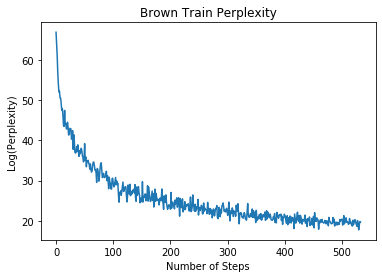

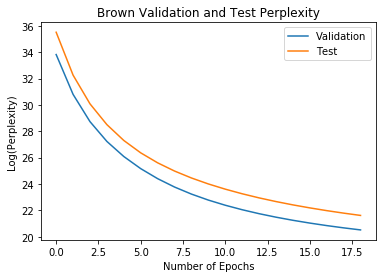

In [66]:
plt.plot(np.log(brown_perplexity_history[1:]))
plt.title('Brown Train Perplexity')
plt.xlabel('Number of Steps')
plt.ylabel('Log(Perplexity)')
plt.savefig(os.path.join(data_path + "/p2", "brown_train_preplexity"))
plt.show()

plt.plot(np.log(brown_val_perplexity_history[1:]))
plt.plot(np.log(brown_test_perplexity_history[1:]))
plt.title('Brown Validation and Test Perplexity')
plt.xlabel('Number of Epochs')
plt.ylabel('Log(Perplexity)')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "brown_test_val_preplexity"))
plt.show()

### Brown Cost

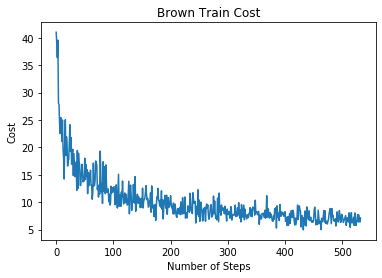

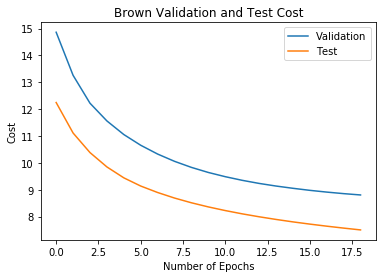

In [65]:
plt.plot(brown_cost_history[1:])
plt.title('Brown Train Cost')
plt.xlabel('Number of Steps')
plt.ylabel('Cost')
plt.savefig(os.path.join(data_path + "/p2", "brown_test_train_cost"))
plt.show()

plt.plot(brown_val_cost_history[1:])
plt.plot(brown_test_cost_history[1:])
plt.title('Brown Validation and Test Cost')
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "brown_test_val_cost"))
plt.show()

## Plot Corpus Perplexity and Cost

### Corpus Perplexity

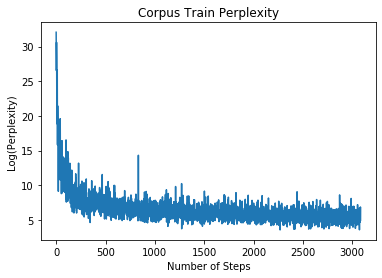

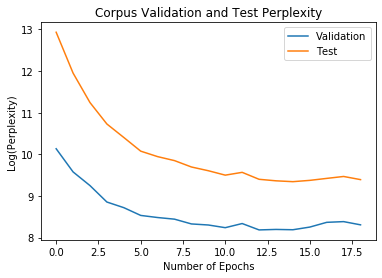

In [90]:
perplexity_history = pickle.load(open(os.path.join(data_path + "/p2",'p2_run02_perplexity_history.p'), "rb"))
cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run02_cost_history.p'), "rb"))
val_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run02_val_perplexity_history.p'), "rb"))
val_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run02_val_cost_history.p'), "rb"))
test_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run02_test_perplexity_history.p'), "rb"))
test_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run02_test_cost_history.p'), "rb"))

plt.plot(np.log(perplexity_history[1:]))
plt.title('Corpus Train Perplexity')
plt.xlabel('Number of Steps')
plt.ylabel('Log(Perplexity)')
plt.savefig(os.path.join(data_path + "/p2", "run02_train_perplexity"))
plt.show()

plt.plot(np.log(val_perplexity_history[1:]))
plt.plot(np.log(test_perplexity_history[1:]))
plt.title('Corpus Validation and Test Perplexity')
plt.xlabel('Number of Epochs')
plt.ylabel('Log(Perplexity)')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "run02_test_val_perplexity"))
plt.show()

### Corpus Cost

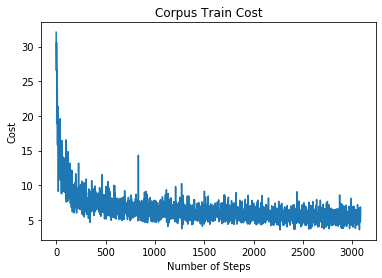

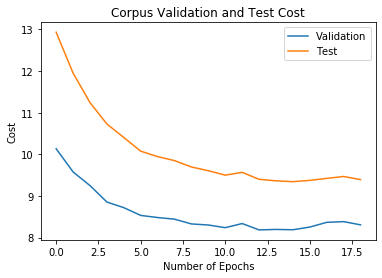

In [91]:
plt.plot(cost_history[1:])
plt.title('Corpus Train Cost')
plt.xlabel('Number of Steps')
plt.ylabel('Cost')
plt.savefig(os.path.join(data_path + "/p2", "run02_train_cost"))
plt.show()

plt.plot(val_cost_history[1:])
plt.plot(test_cost_history[1:])
plt.title('Corpus Validation and Test Cost')
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "run02_test_val_cost"))
plt.show()

In [50]:
# new model arch

class BengioModel2():
  """
  Class implements Bengio NN model with Tensorflow accoring to the function:
    y = b + Wx + Utanh(d + Htanh(v + Px))
    y = b + Wx + Utanh(d + Hx)

  """

  def __init__(self, params):

    self.Y = tf.placeholder(
        dtype=params.tf_precision,
        shape=(params.num_batches, params.vocab_len),
        name="Y"
    )
    
    self.X = tf.placeholder(
        tf.int32, 
        shape=(params.num_batches, params.context_window),
        name="X"
    )

    # embeddings
    self.C = tf.Variable(
        tf.truncated_normal(
            shape=(params.vocab_len, params.embeddings_dim),
            mean=-1,
            stddev=-1
        ),
        dtype=params.tf_precision,
        name="C"
    )

    self.W = tf.Variable(
        tf.random_normal(
            shape=(params.vocab_len, params.context_window * params.embeddings_dim)
        ),
        name="W",
        dtype=params.tf_precision
    )
    
    self.H = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units, params.context_window * params.embeddings_dim)
        ),
        name="H",
        dtype=params.tf_precision
    )

    self.d = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units,)
        ),
        name="d",
        dtype=params.tf_precision
    )

    self.P = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units2, params.context_window * params.embeddings_dim)
        ),
        name="P",
        dtype=params.tf_precision
    )

    self.v = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units2,)
        ),
        name="v",
        dtype=params.tf_precision
    )

    self.U = tf.Variable(
        tf.random_normal(
            (params.vocab_len, params.hidden_units)
        ),
        name="U",
        dtype=params.tf_precision
    )

    self.b = tf.Variable(
        tf.random_normal(
            shape=(params.vocab_len, )
        ),
        name="b",
        dtype=params.tf_precision
    )

    with tf.name_scope("Projection_Layer"):
      x = tf.nn.embedding_lookup(self.C, self.X)
      x = tf.reshape(
          x,
          shape=(params.num_batches, params.context_window * params.embeddings_dim)
      )

    with tf.name_scope("Hidden_Layer"):
      Px = tf.matmul(x, tf.transpose(self.P))
      a = tf.nn.tanh(tf.add(Px, self.v))
      Hx = tf.matmul(a, tf.transpose(self.H))
      a = tf.nn.tanh(tf.add(Hx, self.d))

    with tf.name_scope("Output_Layer"):
      Ua = tf.matmul(a, tf.transpose(self.U))
      Wx = tf.matmul(x, tf.transpose(self.W))
      Y_hat = tf.add(self.b, tf.add(Wx, Ua)) 

    with tf.name_scope("Cost"):
     self.cost = tf.reduce_mean( 
        tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=self.Y,
            logits=Y_hat
        )
      )
    #  self.perplexity = tf.exp(self.cost)

     with tf.name_scope("Perplexity"):
       softmax = tf.reduce_mean(tf.log(tf.nn.softmax(Y_hat)))
       self.perplexity = tf.exp(tf.multiply(softmax, -1))

    self.optimizer = tf.train.GradientDescentOptimizer(params.learning_rate).minimize(self.cost)

In [52]:
int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))

train_batches_int = gen_batches(5, 30, int_train)
val_batches_int = gen_batches(5, 30, int_validation)
test_batches_int = gen_batches(5, 30, int_test)

params = BengioParams(name="p2_run03", vocab_dict=vocab_dict)
params.embedding_dimensions = 100
params.hidden_units = 100
params.hidden_units2 = 120
params.context_window = 2
params.gpu_mem = .9

model = BengioModel2(params=params)

perplexity_history,  cost_history, val_perplexity_history, val_cost_history, test_perplexity_history, test_cost_history = run(model, params, train_batches_int, val_batches_int, test_batches_int)

pickle.dump(perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run04_perplexity_history.p'), 'wb'))
pickle.dump(cost_history, open(os.path.join(data_path + "/p2/", 'p2_run04_cost_history.p'), 'wb'))
pickle.dump(val_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run04_val_perplexity_history.p'), 'wb'))
pickle.dump(val_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run04_val_cost_history.p'), 'wb'))
pickle.dump(test_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run04_test_perplexity_history.p'), 'wb'))
pickle.dump(test_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run04_test_cost_history.p'), 'wb'))

28
6
7
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

train: step 0, cost: 76.2040023803711, perplexity: 2.1077515279508934e+32
train: step 1000, cost: 23.378679275512695, perplexity: 7.411853622521731e+19
train: step 2000, cost: 21.27417755126953, perplexity: 5.78668228054614e+17
train: step 3000, cost: 21.152624130249023, perplexity: 2.198731197775872e+16
train: step 4000, cost: 16.554771423339844, perplexity: 3093286986186752.0
train: step 5000, cost: 19.425439834594727, perplexity: 3.934808088929894e+16
train: step 6000, cost: 21.365421295166016, perplexity: 2912733003513856.0
train: step 7000, cost: 17.117961883544922, perplexity: 7185279496486912.0
train: step 8000, cost: 13.060683250427246, perplexity: 39968730775552.0
train: step

train: step 110000, cost: 9.237030029296875, perplexity: 402656526336.0
train: step 111000, cost: 9.487265586853027, perplexity: 22921494528.0
train: step 112000, cost: 15.384206771850586, perplexity: 218338836480.0
train: step 113000, cost: 8.26290512084961, perplexity: 14342755328.0
train: step 114000, cost: 10.872478485107422, perplexity: 709638160384.0
train: step 115000, cost: 8.208723068237305, perplexity: 8691940352.0
train: step 116000, cost: 5.286678791046143, perplexity: 6019066368.0
train: step 117000, cost: 10.374231338500977, perplexity: 6158984704.0
train: step 118000, cost: 9.232885360717773, perplexity: 32033505280.0
train: step 119000, cost: 11.050216674804688, perplexity: 3129728512.0
train: step 120000, cost: 10.60901927947998, perplexity: 6341004288.0
train: step 121000, cost: 8.0949068069458, perplexity: 7851360768.0
train: step 122000, cost: 9.235044479370117, perplexity: 7843877376.0
train: step 123000, cost: 9.04339599609375, perplexity: 4621452800.0
train: step

train: step 224000, cost: 10.836926460266113, perplexity: 1385784192.0
train: step 225000, cost: 9.579001426696777, perplexity: 8692172800.0
train: step 226000, cost: 7.418045997619629, perplexity: 812787072.0
train: step 227000, cost: 8.831345558166504, perplexity: 2211205632.0
train: step 228000, cost: 8.922666549682617, perplexity: 15925964800.0
train: step 229000, cost: 9.873584747314453, perplexity: 3085893888.0
train: step 230000, cost: 8.68572998046875, perplexity: 791668032.0
train: step 231000, cost: 7.917684078216553, perplexity: 111226601472.0
train: step 232000, cost: 10.029535293579102, perplexity: 1928607360.0
train: step 233000, cost: 8.774182319641113, perplexity: 8001085440.0
train: step 234000, cost: 8.192750930786133, perplexity: 3832656384.0
train: step 235000, cost: 7.851661205291748, perplexity: 1358547840.0
train: step 236000, cost: 12.978468894958496, perplexity: 126429913088.0
train: step 237000, cost: 9.792801856994629, perplexity: 3098745856.0
train: step 238

train: step 338000, cost: 7.3807220458984375, perplexity: 80022659072.0
train: step 339000, cost: 8.312359809875488, perplexity: 1508147072.0
train: step 340000, cost: 9.55913257598877, perplexity: 929130112.0
train: step 341000, cost: 9.438077926635742, perplexity: 432882464.0
train: step 342000, cost: 5.378904342651367, perplexity: 1541568987136.0
train: step 343000, cost: 7.777574062347412, perplexity: 334288128.0
train: step 344000, cost: 7.756132125854492, perplexity: 7839659008.0
train: step 345000, cost: 6.841629505157471, perplexity: 1246000768.0
train: step 346000, cost: 9.169986724853516, perplexity: 968851392.0
train: step 347000, cost: 8.757973670959473, perplexity: 792263104.0
train: step 348000, cost: 8.469988822937012, perplexity: 519366816.0
train: step 349000, cost: 10.076263427734375, perplexity: 964045824.0
train: step 350000, cost: 9.20026969909668, perplexity: 830469952.0
train: step 351000, cost: 11.328782081604004, perplexity: 15288095744.0
train: step 352000, co

train: step 456000, cost: 9.59400463104248, perplexity: 590169856.0
train: step 457000, cost: 7.167393207550049, perplexity: 783693376.0
train: step 458000, cost: 7.85498046875, perplexity: 60052058112.0
train: step 459000, cost: 8.223479270935059, perplexity: 14801205248.0
train: step 460000, cost: 8.19190788269043, perplexity: 658203776.0
train: step 461000, cost: 7.985991477966309, perplexity: 696505024.0
train: step 462000, cost: 7.181183815002441, perplexity: 7268527616.0
Model saved in path: ../data/tmp/p2_run03_3.ckpt
validation: epoch 3, cost: 11.012782096862793, perplexity: 1851486080.0
test: epoch 3, cost: 10.25096607208252, perplexity: [5715784700.0, 8915511000.0, 2598300700.0]
train: step 463000, cost: 7.195276737213135, perplexity: 26753767424.0
train: step 464000, cost: 9.351710319519043, perplexity: 13448122368.0
train: step 465000, cost: 6.562205791473389, perplexity: 11204589568.0
train: step 466000, cost: 9.00464153289795, perplexity: 13925812224.0
train: step 467000,

train: step 571000, cost: 7.684954643249512, perplexity: 384083616.0
train: step 572000, cost: 6.370491027832031, perplexity: 11939810304.0
train: step 573000, cost: 7.827652931213379, perplexity: 750169728.0
train: step 574000, cost: 10.427438735961914, perplexity: 1532984320.0
train: step 575000, cost: 7.040541648864746, perplexity: 1314090240.0
train: step 576000, cost: 5.9134392738342285, perplexity: 1746927104.0
train: step 577000, cost: 6.547248363494873, perplexity: 974730816.0
train: step 578000, cost: 8.060141563415527, perplexity: 935053760.0
train: step 579000, cost: 6.7023606300354, perplexity: 1452316928.0
train: step 580000, cost: 10.520007133483887, perplexity: 1139128192.0
train: step 581000, cost: 9.077234268188477, perplexity: 3620535040.0
train: step 582000, cost: 7.130147457122803, perplexity: 553134144.0
train: step 583000, cost: 8.72055721282959, perplexity: 45700530176.0
train: step 584000, cost: 7.299440860748291, perplexity: 1387021568.0
train: step 585000, cos

train: step 685000, cost: 8.545397758483887, perplexity: 21551529984.0
train: step 686000, cost: 8.569289207458496, perplexity: 18198294528.0
train: step 687000, cost: 8.444170951843262, perplexity: 23189078016.0
train: step 688000, cost: 12.367087364196777, perplexity: 5847882752.0
train: step 689000, cost: 8.854764938354492, perplexity: 374800064.0
train: step 690000, cost: 6.737548828125, perplexity: 4259073536.0
train: step 691000, cost: 6.126047134399414, perplexity: 1189944960.0
train: step 692000, cost: 10.450982093811035, perplexity: 6278747136.0
train: step 693000, cost: 9.46251392364502, perplexity: 1349730176.0
train: step 694000, cost: 8.214936256408691, perplexity: 3257650688.0
train: step 695000, cost: 7.5643815994262695, perplexity: 451126144.0
train: step 696000, cost: 8.59597396850586, perplexity: 8487855616.0
train: step 697000, cost: 6.876220703125, perplexity: 168013643776.0
train: step 698000, cost: 10.005959510803223, perplexity: 9989432320.0
train: step 699000, c

train: step 799000, cost: 7.237807273864746, perplexity: 27728027648.0
train: step 800000, cost: 7.722578048706055, perplexity: 1355405696.0
train: step 801000, cost: 11.86203384399414, perplexity: 625548224.0
train: step 802000, cost: 7.159018039703369, perplexity: 1759681664.0
train: step 803000, cost: 8.711747169494629, perplexity: 2688706560.0
train: step 804000, cost: 7.05427360534668, perplexity: 33859172352.0
train: step 805000, cost: 8.72270393371582, perplexity: 554641728.0
train: step 806000, cost: 8.542952537536621, perplexity: 7946137600.0
train: step 807000, cost: 6.98890495300293, perplexity: 1115790080.0
train: step 808000, cost: 8.341721534729004, perplexity: 734796352.0
train: step 809000, cost: 5.981221675872803, perplexity: 255521264.0
train: step 810000, cost: 6.494818210601807, perplexity: 14798889984.0
train: step 811000, cost: 5.933083534240723, perplexity: 681724096.0
train: step 812000, cost: 5.252958297729492, perplexity: 1143060992.0
train: step 813000, cost:

train: step 917000, cost: 7.5802154541015625, perplexity: 1505523072.0
train: step 918000, cost: 9.111680030822754, perplexity: 1785511680.0
train: step 919000, cost: 7.536052227020264, perplexity: 1846837376.0
train: step 920000, cost: 7.436556816101074, perplexity: 1113054336.0
train: step 921000, cost: 7.687204360961914, perplexity: 3768295424.0
train: step 922000, cost: 9.665480613708496, perplexity: 2288932864.0
train: step 923000, cost: 7.793591022491455, perplexity: 2011302912.0
train: step 924000, cost: 15.21859073638916, perplexity: 496267168.0
train: step 925000, cost: 6.19032096862793, perplexity: 8928325632.0
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Model saved in path: ../data/tmp/p2_run03_6.ckpt
validation: epoch 6, cost: 9.357161521911621, perplexity: 2159830784.0
test: epoch 6, cost: 8.567289352416992, perplexity: [5715784700.0, 8915511000.0, 2598300700.0, 1228003700.0, 2610914000.0, 2938851800.0]
train: step 926000, cost: 7.44

train: step 1026000, cost: 8.399264335632324, perplexity: 2624374528.0
train: step 1027000, cost: 8.59583568572998, perplexity: 2076720384.0
train: step 1028000, cost: 7.915821552276611, perplexity: 14244963328.0
train: step 1029000, cost: 8.108238220214844, perplexity: 631264192.0
train: step 1030000, cost: 8.412627220153809, perplexity: 3688150016.0
train: step 1031000, cost: 9.921528816223145, perplexity: 2068379520.0
train: step 1032000, cost: 7.551808834075928, perplexity: 2062163456.0
train: step 1033000, cost: 6.345341205596924, perplexity: 120156413952.0
train: step 1034000, cost: 9.615938186645508, perplexity: 2946530048.0
train: step 1035000, cost: 7.72628116607666, perplexity: 1012858176.0
train: step 1036000, cost: 7.33834171295166, perplexity: 754078976.0
train: step 1037000, cost: 6.562616348266602, perplexity: 3988023808.0
train: step 1038000, cost: 7.5684814453125, perplexity: 12974764032.0
train: step 1039000, cost: 7.525630474090576, perplexity: 185427984384.0
train: 

train: step 1138000, cost: 7.849341869354248, perplexity: 9036998656.0
train: step 1139000, cost: 7.444291114807129, perplexity: 156004251598848.0
train: step 1140000, cost: 8.708069801330566, perplexity: 2054417792.0
train: step 1141000, cost: 7.889876365661621, perplexity: 2105179648.0
train: step 1142000, cost: 9.248005867004395, perplexity: 1019838720.0
train: step 1143000, cost: 7.853965759277344, perplexity: 2898962432.0
train: step 1144000, cost: 7.7121124267578125, perplexity: 7346551296.0
train: step 1145000, cost: 9.885519027709961, perplexity: 10461509632.0
train: step 1146000, cost: 7.427021503448486, perplexity: 1193317888.0
train: step 1147000, cost: 6.957462787628174, perplexity: 119000064000.0
train: step 1148000, cost: 6.785712718963623, perplexity: 1169514112.0
train: step 1149000, cost: 6.931217670440674, perplexity: 8668133376.0
train: step 1150000, cost: 9.019272804260254, perplexity: 1605114240.0
train: step 1151000, cost: 7.017521381378174, perplexity: 1952142540

train: step 1250000, cost: 9.78039836883545, perplexity: 2857122304.0
train: step 1251000, cost: 7.45505952835083, perplexity: 9862211584.0
train: step 1252000, cost: 6.812521457672119, perplexity: 45166469120.0
train: step 1253000, cost: 6.073282241821289, perplexity: 140207521792.0
train: step 1254000, cost: 7.732029438018799, perplexity: 29289930752.0
train: step 1255000, cost: 7.821386814117432, perplexity: 491847616.0
train: step 1256000, cost: 6.7346577644348145, perplexity: 3932970752.0
train: step 1257000, cost: 5.514326095581055, perplexity: 5482859008.0
train: step 1258000, cost: 6.489419937133789, perplexity: 305176768.0
train: step 1259000, cost: 5.620205879211426, perplexity: 2412794880.0
train: step 1260000, cost: 5.553624629974365, perplexity: 5510830592.0
train: step 1261000, cost: 7.679903984069824, perplexity: 1721799680.0
train: step 1262000, cost: 7.729251384735107, perplexity: 3912462592.0
train: step 1263000, cost: 6.725943565368652, perplexity: 7990928384.0
train

train: step 1366000, cost: 9.429760932922363, perplexity: 5385585664.0
train: step 1367000, cost: 6.765474319458008, perplexity: 1000815552.0
train: step 1368000, cost: 7.729916572570801, perplexity: 901060928.0
train: step 1369000, cost: 7.465742111206055, perplexity: 61996969984.0
train: step 1370000, cost: 6.697464466094971, perplexity: 11593140224.0
train: step 1371000, cost: 7.461276531219482, perplexity: 69690834944.0
train: step 1372000, cost: 6.0134172439575195, perplexity: 662995520.0
train: step 1373000, cost: 10.07075023651123, perplexity: 64313741312.0
train: step 1374000, cost: 5.701572895050049, perplexity: 2193236480.0
train: step 1375000, cost: 8.885263442993164, perplexity: 10624592896.0
train: step 1376000, cost: 9.159465789794922, perplexity: 363860192.0
train: step 1377000, cost: 7.569793701171875, perplexity: 845835776.0
train: step 1378000, cost: 7.529224872589111, perplexity: 2899714304.0
train: step 1379000, cost: 7.9402546882629395, perplexity: 6431100928.0
tra

train: step 1477000, cost: 8.331144332885742, perplexity: 13486190592.0
train: step 1478000, cost: 6.560805320739746, perplexity: 3006427904.0
train: step 1479000, cost: 7.049933910369873, perplexity: 127647490048.0
train: step 1480000, cost: 7.279726028442383, perplexity: 147186696192.0
train: step 1481000, cost: 7.3606181144714355, perplexity: 4554622464.0
train: step 1482000, cost: 7.01759147644043, perplexity: 19979902976.0
train: step 1483000, cost: 7.139963626861572, perplexity: 2086909440.0
train: step 1484000, cost: 8.065741539001465, perplexity: 9793754112.0
train: step 1485000, cost: 7.172774791717529, perplexity: 4174075392.0
train: step 1486000, cost: 8.338098526000977, perplexity: 5845841920.0
train: step 1487000, cost: 7.8786540031433105, perplexity: 1512427776.0
train: step 1488000, cost: 6.849603176116943, perplexity: 2675257856.0
train: step 1489000, cost: 6.489024639129639, perplexity: 895800128.0
train: step 1490000, cost: 10.119491577148438, perplexity: 659600000.0


train: step 1588000, cost: 6.124016284942627, perplexity: 5015984128.0
train: step 1589000, cost: 9.671056747436523, perplexity: 34195881984.0
train: step 1590000, cost: 7.259838581085205, perplexity: 745243904.0
train: step 1591000, cost: 8.754636764526367, perplexity: 1036072832.0
train: step 1592000, cost: 6.340779781341553, perplexity: 3466263040.0
train: step 1593000, cost: 5.619313716888428, perplexity: 7831588352.0
train: step 1594000, cost: 7.071671962738037, perplexity: 13431768064.0
train: step 1595000, cost: 6.370384693145752, perplexity: 534193766400.0
train: step 1596000, cost: 7.4170379638671875, perplexity: 49142521856.0
train: step 1597000, cost: 6.560323238372803, perplexity: 7154760704.0
train: step 1598000, cost: 8.39193344116211, perplexity: 1574573056.0
train: step 1599000, cost: 5.294572353363037, perplexity: 33842771968.0
train: step 1600000, cost: 8.890803337097168, perplexity: 23008706560.0
train: step 1601000, cost: 7.910542011260986, perplexity: 3415356160.0


train: step 1699000, cost: 7.013948440551758, perplexity: 1525144960.0
train: step 1700000, cost: 8.284406661987305, perplexity: 1331514112.0
train: step 1701000, cost: 7.018259525299072, perplexity: 11537331200.0
train: step 1702000, cost: 8.156492233276367, perplexity: 12445810688.0
train: step 1703000, cost: 7.70831823348999, perplexity: 1622384512.0
train: step 1704000, cost: 14.71113395690918, perplexity: 1391544832.0
train: step 1705000, cost: 4.952038288116455, perplexity: 6735186944.0
train: step 1706000, cost: 7.878195285797119, perplexity: 1671711744.0
train: step 1707000, cost: 11.489249229431152, perplexity: 43650859008.0
train: step 1708000, cost: 7.1455512046813965, perplexity: 2932049152.0
train: step 1709000, cost: 13.186742782592773, perplexity: 2935792896.0
train: step 1710000, cost: 6.912806034088135, perplexity: 4431803392.0
train: step 1711000, cost: 7.2311835289001465, perplexity: 3688143104.0
train: step 1712000, cost: 9.651383399963379, perplexity: 2250430976.0


train: step 1814000, cost: 6.598526954650879, perplexity: 4703209472.0
train: step 1815000, cost: 8.860848426818848, perplexity: 1284058240.0
train: step 1816000, cost: 6.7602434158325195, perplexity: 1112814464.0
train: step 1817000, cost: 7.266350269317627, perplexity: 2039235072.0
train: step 1818000, cost: 9.532946586608887, perplexity: 3500746496.0
train: step 1819000, cost: 8.577526092529297, perplexity: 5231620096.0
train: step 1820000, cost: 5.3366312980651855, perplexity: 119905034240.0
train: step 1821000, cost: 6.290080547332764, perplexity: 2391603968.0
train: step 1822000, cost: 8.007070541381836, perplexity: 5572856320.0
train: step 1823000, cost: 8.063885688781738, perplexity: 2186077952.0
train: step 1824000, cost: 6.866364002227783, perplexity: 2625210624.0
train: step 1825000, cost: 6.632424831390381, perplexity: 56357974016.0
train: step 1826000, cost: 6.249548435211182, perplexity: 2059671296.0
train: step 1827000, cost: 6.427480220794678, perplexity: 949675098112.0

train: step 1924000, cost: 7.300443649291992, perplexity: 13122448384.0
train: step 1925000, cost: 7.467235088348389, perplexity: 1742727168.0
train: step 1926000, cost: 6.70648717880249, perplexity: 5290917376.0
train: step 1927000, cost: 8.559112548828125, perplexity: 4234336512.0
train: step 1928000, cost: 6.239807605743408, perplexity: 7602155008.0
train: step 1929000, cost: 6.277192115783691, perplexity: 20029583360.0
train: step 1930000, cost: 5.547147750854492, perplexity: 37218037760.0
train: step 1931000, cost: 7.489818096160889, perplexity: 98094997504.0
train: step 1932000, cost: 6.207001686096191, perplexity: 18139107328.0
train: step 1933000, cost: 6.041422367095947, perplexity: 6178339328.0
train: step 1934000, cost: 7.9190263748168945, perplexity: 1955495424.0
train: step 1935000, cost: 7.201234817504883, perplexity: 79697600512.0
train: step 1936000, cost: 7.655995845794678, perplexity: 796323328.0
train: step 1937000, cost: 7.751575946807861, perplexity: 2153767168.0
t

train: step 2034000, cost: 8.469524383544922, perplexity: 1917233135616.0
train: step 2035000, cost: 7.0636677742004395, perplexity: 15484186624.0
train: step 2036000, cost: 6.424110412597656, perplexity: 23716677632.0
train: step 2037000, cost: 7.666758060455322, perplexity: 51908014080.0
train: step 2038000, cost: 7.985334396362305, perplexity: 946611904.0
train: step 2039000, cost: 6.575170040130615, perplexity: 17896450048.0
train: step 2040000, cost: 9.204771041870117, perplexity: 1639074688.0
train: step 2041000, cost: 10.721712112426758, perplexity: 12522292224.0
train: step 2042000, cost: 6.292997360229492, perplexity: 1967403648.0
train: step 2043000, cost: 7.761448383331299, perplexity: 1340803456.0
train: step 2044000, cost: 8.44027042388916, perplexity: 30169876480.0
train: step 2045000, cost: 6.179104804992676, perplexity: 7118702080.0
train: step 2046000, cost: 7.700811862945557, perplexity: 7132429312.0
train: step 2047000, cost: 5.675990104675293, perplexity: 2708161536

train: step 2149000, cost: 6.849462985992432, perplexity: 459067520.0
train: step 2150000, cost: 7.5574631690979, perplexity: 250007584.0
train: step 2151000, cost: 6.416513442993164, perplexity: 21191397376.0
train: step 2152000, cost: 7.054927349090576, perplexity: 2481582080.0
train: step 2153000, cost: 10.784993171691895, perplexity: 35136389120.0
train: step 2154000, cost: 6.930895805358887, perplexity: 2249032192.0
train: step 2155000, cost: 5.8970255851745605, perplexity: 1528616320.0
train: step 2156000, cost: 5.696199417114258, perplexity: 2158302976.0
train: step 2157000, cost: 8.61498737335205, perplexity: 8161896960.0
train: step 2158000, cost: 12.10448169708252, perplexity: 2564603136.0
train: step 2159000, cost: 7.62564754486084, perplexity: 1542831488.0
Model saved in path: ../data/tmp/p2_run03_14.ckpt
validation: epoch 14, cost: 9.891836166381836, perplexity: 2808206080.0
test: epoch 14, cost: 9.026991844177246, perplexity: [5715784700.0, 8915511000.0, 2598300700.0, 122

train: step 2259000, cost: 7.142369747161865, perplexity: 6284329984.0
train: step 2260000, cost: 8.716874122619629, perplexity: 2386259200.0
train: step 2261000, cost: 6.943986892700195, perplexity: 18899679232.0
train: step 2262000, cost: 7.711876392364502, perplexity: 5159892480.0
train: step 2263000, cost: 5.022994041442871, perplexity: 19746867200.0
train: step 2264000, cost: 6.601499557495117, perplexity: 21604208640.0
train: step 2265000, cost: 7.999189376831055, perplexity: 8816164864.0
train: step 2266000, cost: 8.4170560836792, perplexity: 3928187648.0
train: step 2267000, cost: 6.537024974822998, perplexity: 12232867840.0
train: step 2268000, cost: 6.325471878051758, perplexity: 4030456576.0
train: step 2269000, cost: 9.194646835327148, perplexity: 54479187968.0
train: step 2270000, cost: 7.756692886352539, perplexity: 208816963584.0
train: step 2271000, cost: 7.763077259063721, perplexity: 4481812480.0
train: step 2272000, cost: 6.946633815765381, perplexity: 4454200832.0
t

train: step 2369000, cost: 6.19847297668457, perplexity: 7130307072.0
train: step 2370000, cost: 6.0256667137146, perplexity: 4899088384.0
train: step 2371000, cost: 7.2448272705078125, perplexity: 1832814720.0
train: step 2372000, cost: 7.531465530395508, perplexity: 674422080.0
train: step 2373000, cost: 8.444866180419922, perplexity: 34823409664.0
train: step 2374000, cost: 10.332856178283691, perplexity: 677753913344.0
train: step 2375000, cost: 7.1884765625, perplexity: 2921102592.0
train: step 2376000, cost: 7.94672966003418, perplexity: 1098654720.0
train: step 2377000, cost: 7.2376790046691895, perplexity: 6222498304.0
train: step 2378000, cost: 6.269895553588867, perplexity: 2514265344.0
train: step 2379000, cost: 6.432058334350586, perplexity: 14151452672.0
train: step 2380000, cost: 7.783881187438965, perplexity: 632709568.0
train: step 2381000, cost: 9.001855850219727, perplexity: 5622326938828800.0
train: step 2382000, cost: 5.41649866104126, perplexity: 11221164032.0
trai

train: step 2478000, cost: 6.43774938583374, perplexity: 42476290048.0
train: step 2479000, cost: 14.135015487670898, perplexity: 4388274176.0
train: step 2480000, cost: 5.959073543548584, perplexity: 8373925888.0
train: step 2481000, cost: 8.2881498336792, perplexity: 9871885312.0
train: step 2482000, cost: 6.106818675994873, perplexity: 4371958272.0
train: step 2483000, cost: 4.613618850708008, perplexity: 26156754944.0
train: step 2484000, cost: 5.293549537658691, perplexity: 3456676608.0
train: step 2485000, cost: 6.479069709777832, perplexity: 3154528000.0
train: step 2486000, cost: 6.882437229156494, perplexity: 5577056256.0
train: step 2487000, cost: 6.143941402435303, perplexity: 35846959104.0
train: step 2488000, cost: 7.959834098815918, perplexity: 38515429376.0
train: step 2489000, cost: 5.885016918182373, perplexity: 3921151232.0
train: step 2490000, cost: 6.250056743621826, perplexity: 10665179136.0
train: step 2491000, cost: 7.745798110961914, perplexity: 1044419840.0
tra

train: step 2593000, cost: 8.166054725646973, perplexity: 3711423744.0
train: step 2594000, cost: 7.8178277015686035, perplexity: 26592847872.0
train: step 2595000, cost: 7.215909481048584, perplexity: 1397180416.0
train: step 2596000, cost: 6.5245585441589355, perplexity: 106574372864.0
train: step 2597000, cost: 8.390832901000977, perplexity: 9351843840.0
train: step 2598000, cost: 5.8105244636535645, perplexity: 233173532672.0
train: step 2599000, cost: 7.3837761878967285, perplexity: 57732222976.0
train: step 2600000, cost: 6.1486663818359375, perplexity: 3688256000.0
train: step 2601000, cost: 7.544552803039551, perplexity: 25294039040.0
train: step 2602000, cost: 8.093149185180664, perplexity: 5211075072.0
train: step 2603000, cost: 4.888844013214111, perplexity: 13596060672.0
train: step 2604000, cost: 8.349658966064453, perplexity: 1306731904.0
train: step 2605000, cost: 6.155152320861816, perplexity: 1166068352.0
train: step 2606000, cost: 15.601533889770508, perplexity: 14604

train: step 2702000, cost: 6.0262932777404785, perplexity: 3477023488.0
train: step 2703000, cost: 6.709559917449951, perplexity: 22632081408.0
train: step 2704000, cost: 7.001980781555176, perplexity: 4495553024.0
train: step 2705000, cost: 6.53772497177124, perplexity: 10066896896.0
train: step 2706000, cost: 7.328722953796387, perplexity: 6338343936.0
train: step 2707000, cost: 7.929514408111572, perplexity: 1186887168.0
train: step 2708000, cost: 6.217023849487305, perplexity: 91451850752.0
train: step 2709000, cost: 7.008390426635742, perplexity: 4571559424.0
train: step 2710000, cost: 6.468475818634033, perplexity: 24426393600.0
train: step 2711000, cost: 9.05124282836914, perplexity: 1361502464.0
train: step 2712000, cost: 7.425194263458252, perplexity: 22401882112.0
train: step 2713000, cost: 7.2994771003723145, perplexity: 903566720.0
train: step 2714000, cost: 8.26943588256836, perplexity: 147294830592.0
train: step 2715000, cost: 7.9571452140808105, perplexity: 19159189504.0

train: step 2811000, cost: 6.5084991455078125, perplexity: 2334576640.0
train: step 2812000, cost: 8.674086570739746, perplexity: 5296450048.0
train: step 2813000, cost: 5.483152389526367, perplexity: 13678280704.0
train: step 2814000, cost: 8.014646530151367, perplexity: 35974766592.0
train: step 2815000, cost: 8.466093063354492, perplexity: 5930543616.0
train: step 2816000, cost: 9.043917655944824, perplexity: 2647304704.0
train: step 2817000, cost: 6.788508415222168, perplexity: 18809485312.0
train: step 2818000, cost: 6.91070556640625, perplexity: 85443698688.0
train: step 2819000, cost: 7.196978569030762, perplexity: 17862109184.0
train: step 2820000, cost: 5.967669486999512, perplexity: 1552510848.0
train: step 2821000, cost: 9.975729942321777, perplexity: 17126426624.0
train: step 2822000, cost: 7.3599534034729, perplexity: 740829248.0
train: step 2823000, cost: 7.228706359863281, perplexity: 19044278272.0
train: step 2824000, cost: 6.1657633781433105, perplexity: 14135186432.0


train: step 2926000, cost: 7.054011344909668, perplexity: 5893815808.0
train: step 2927000, cost: 8.192039489746094, perplexity: 2449916672.0
train: step 2928000, cost: 7.125331401824951, perplexity: 912581459968.0
train: step 2929000, cost: 9.799702644348145, perplexity: 9867253760.0
train: step 2930000, cost: 6.377758979797363, perplexity: 4798406144.0
train: step 2931000, cost: 6.314915657043457, perplexity: 5973432832.0
Model saved in path: ../data/tmp/p2_run03_19.ckpt
validation: epoch 19, cost: 10.867837905883789, perplexity: 22713638912.0
test: epoch 19, cost: 9.914551734924316, perplexity: [5715784700.0, 8915511000.0, 2598300700.0, 1228003700.0, 2610914000.0, 2938851800.0, 959963200.0, 10178552000.0, 1916861000.0, 10158847000.0, 2516938000.0, 7243974700.0, 3632418600.0, 4125815800.0, 17636676000.0, 4492741600.0, 5698183000.0, 5549256000.0, 43924468000.0]
train: step 2932000, cost: 8.154050827026367, perplexity: 4106698496.0
train: step 2933000, cost: 7.3214826583862305, perplex

train: step 3034000, cost: 7.557358264923096, perplexity: 7711994880.0
train: step 3035000, cost: 5.1175537109375, perplexity: 60187942912.0
train: step 3036000, cost: 7.645315647125244, perplexity: 4831661568.0
train: step 3037000, cost: 7.529012203216553, perplexity: 17677123584.0
train: step 3038000, cost: 6.414461135864258, perplexity: 2115032064.0
train: step 3039000, cost: 6.452816963195801, perplexity: 2759432192.0
train: step 3040000, cost: 8.743871688842773, perplexity: 270487060480.0
train: step 3041000, cost: 11.299304962158203, perplexity: 31361955840.0
train: step 3042000, cost: 7.26130485534668, perplexity: 6939289600.0
train: step 3043000, cost: 6.923773288726807, perplexity: 1544636416.0
train: step 3044000, cost: 6.2618937492370605, perplexity: 67331223552.0
train: step 3045000, cost: 6.199558734893799, perplexity: 15255033856.0
train: step 3046000, cost: 4.723453998565674, perplexity: 7913150976.0
train: step 3047000, cost: 10.68673324584961, perplexity: 14542219264.0

### 2 Hidden Layer Perplexity

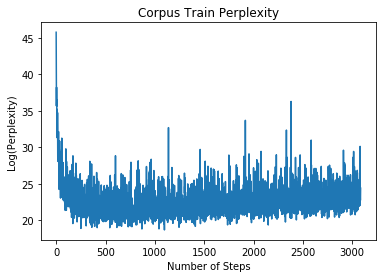

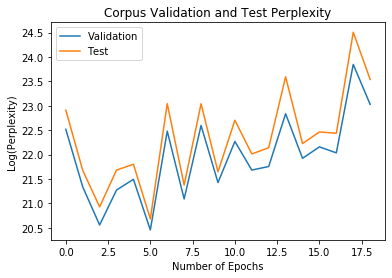

In [92]:
perplexity_history = pickle.load(open(os.path.join(data_path + "/p2",'p2_run04_perplexity_history.p'), "rb"))
cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run04_cost_history.p'), "rb"))
val_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run04_val_perplexity_history.p'), "rb"))
val_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run04_val_cost_history.p'), "rb"))
test_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run04_test_perplexity_history.p'), "rb"))
test_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run04_test_cost_history.p'), "rb"))

plt.plot(np.log(perplexity_history[1:]))
plt.title('Corpus Train Perplexity')
plt.xlabel('Number of Steps')
plt.ylabel('Log(Perplexity)')
plt.savefig(os.path.join(data_path + "/p2", "run04_train_perplexity"))
plt.show()

plt.plot(np.log(val_perplexity_history[1:]))
plt.plot(np.log(test_perplexity_history[1:]))
plt.title('Corpus Validation and Test Perplexity')
plt.xlabel('Number of Epochs')
plt.ylabel('Log(Perplexity)')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "run04_test_val_perplexity"))
plt.show()


### 2 Hidden Layer Cost

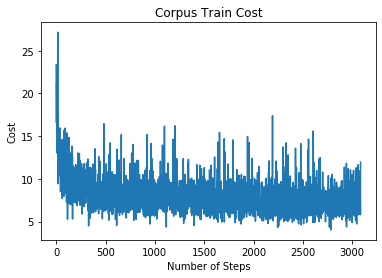

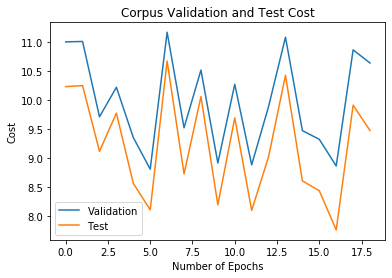

In [93]:
plt.plot(cost_history[1:])
plt.title('Corpus Train Cost')
plt.xlabel('Number of Steps')
plt.ylabel('Cost')
plt.savefig(os.path.join(data_path + "/p2", "run04_train_cost"))
plt.show()

plt.plot(val_cost_history[1:])
plt.plot(test_cost_history[1:])
plt.title('Corpus Validation and Test Cost')
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "run04_test_val_cost"))
plt.show()

### Brown Adjusted Leaning Rate

In [61]:
brown_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'lr01_brown_perplexity_history.p'), "rb"))
brown_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'lr01_brown_cost_history.p'), "rb"))
brown_val_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'lr01_brown_val_perplexity_history.p'), "rb"))
brown_val_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'lr01_brown_val_cost_history.p'), "rb"))
brown_test_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'lr01_brown_test_perplexity_history.p'), "rb"))
brown_test_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'lr01_brown_test_cost_history.p'), "rb"))

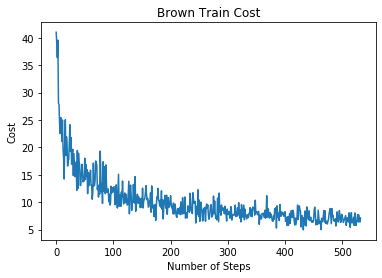

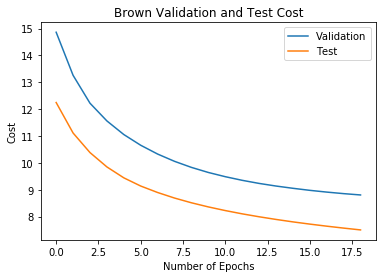

In [63]:
plt.plot(brown_cost_history[1:])
plt.title('Brown Train Cost')
plt.xlabel('Number of Steps')
plt.ylabel('Cost')
plt.savefig(os.path.join(data_path + "/p2", "lr01_brown_test_train_cost"))
plt.show()

plt.plot(brown_val_cost_history[1:])
plt.plot(brown_test_cost_history[1:])
plt.title('Brown Validation and Test Cost')
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "lr01_brown_test_val_cost"))
plt.show()

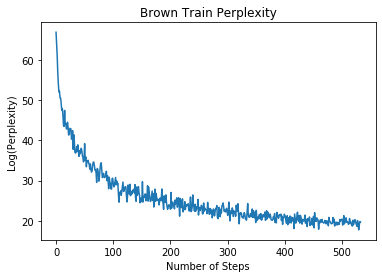

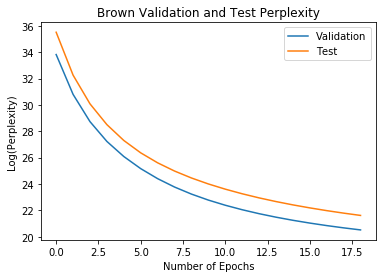

In [64]:
plt.plot(np.log(brown_perplexity_history[1:]))
plt.title('Brown Train Perplexity')
plt.xlabel('Number of Steps')
plt.ylabel('Log(Perplexity)')
plt.savefig(os.path.join(data_path + "/p2", "lr01_brown_train_preplexity"))
plt.show()

plt.plot(np.log(brown_val_perplexity_history[1:]))
plt.plot(np.log(brown_test_perplexity_history[1:]))
plt.title('Brown Validation and Test Perplexity')
plt.xlabel('Number of Epochs')
plt.ylabel('Log(Perplexity)')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "lr01_brown_test_val_preplexity"))
plt.show()

### our corpus Without Weights


In [76]:
class BengioModel_NoWeights():
  """
  Class implements Bengio NN model with Tensorflow accoring to the function:
    y = b + Wx + Utanh(d + Hx)
  
  and 
    cost = softmax_cross_entropy?

  """

  def __init__(self, params):

    self.Y = tf.placeholder(
        dtype=params.tf_precision,
        shape=(params.num_batches, params.vocab_len),
        name="Y"
    )
    
    self.X = tf.placeholder(
        tf.int32, 
        shape=(params.num_batches, params.context_window),
        name="X"
    )

    # embeddings
    self.C = tf.Variable(
        tf.truncated_normal(
            shape=(params.vocab_len, params.embeddings_dim),
            mean=-1,
            stddev=-1
        ),
        dtype=params.tf_precision,
        name="C"
    )

#     self.W = tf.Variable(
#         tf.random_normal(
#             shape=(params.vocab_len, params.context_window * params.embeddings_dim)
#         ),
#         name="W",
#         dtype=params.tf_precision
#     )
    
    self.H = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units, params.context_window * params.embeddings_dim)
        ),
        name="H",
        dtype=params.tf_precision
    )

    self.d = tf.Variable(
        tf.random_normal(
            shape=(params.hidden_units,)
        ),
        name="d",
        dtype=params.tf_precision
    )

    self.U = tf.Variable(
        tf.random_normal(
            (params.vocab_len, params.hidden_units)
        ),
        name="U",
        dtype=params.tf_precision
    )

    self.b = tf.Variable(
        tf.random_normal(
            shape=(params.vocab_len, )
        ),
        name="b",
        dtype=params.tf_precision
    )

    with tf.name_scope("Projection_Layer"):
      x = tf.nn.embedding_lookup(self.C, self.X)
      x = tf.reshape(
          x,
          shape=(params.num_batches, params.context_window * params.embeddings_dim)
      )

    with tf.name_scope("Hidden_Layer"):
      Hx = tf.matmul(x, tf.transpose(self.H))
      a = tf.nn.tanh(tf.add(Hx, self.d))

    with tf.name_scope("Output_Layer"):
      Ua = tf.matmul(a, tf.transpose(self.U))
#       Wx = tf.matmul(x, tf.transpose(self.W))
      Y_hat = tf.add(self.b, Ua) 

    with tf.name_scope("Cost"):
     self.cost = tf.reduce_mean( 
        tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=self.Y,
            logits=Y_hat
        )
      )
    #  self.perplexity = tf.exp(self.cost)

     with tf.name_scope("Perplexity"):
       softmax = tf.reduce_mean(tf.log(tf.nn.softmax(Y_hat)))
       self.perplexity = tf.exp(tf.multiply(softmax, -1))

    self.optimizer = tf.train.GradientDescentOptimizer(params.learning_rate).minimize(self.cost)

In [77]:
int_train = pickle.load(open(os.path.join(data_path, 'group2.int_train.p'), 'rb'))
int_validation = pickle.load(open(os.path.join(data_path, 'group2.int_valid.p'), 'rb'))
int_test = pickle.load(open(os.path.join(data_path, 'group2.int_test.p'), 'rb'))
vocab_dict = pickle.load(open(os.path.join(data_path, 'group2.vocab_dict.p'), 'rb'))

train_batches_int = gen_batches(5, 30, int_train)
val_batches_int = gen_batches(5, 30, int_validation)
test_batches_int = gen_batches(5, 30, int_test)

params = BengioParams(name="p2_run05", vocab_dict=vocab_dict)
params.embedding_dimensions = 100
params.hidden_units = 100
params.context_window = 5
params.gpu_mem = .9

model = BengioModel_NoWeights(params=params)

perplexity_history,  cost_history, val_perplexity_history, val_cost_history, test_perplexity_history, test_cost_history = run(model, params, train_batches_int, val_batches_int, test_batches_int)

pickle.dump(perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run05_perplexity_history.p'), 'wb'))
pickle.dump(cost_history, open(os.path.join(data_path + "/p2/", 'p2_run05_cost_history.p'), 'wb'))
pickle.dump(val_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run05_val_perplexity_history.p'), 'wb'))
pickle.dump(val_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run05_val_cost_history.p'), 'wb'))
pickle.dump(test_perplexity_history, open(os.path.join(data_path + "/p2/", 'p2_run05_test_perplexity_history.p'), 'wb'))
pickle.dump(test_cost_history, open(os.path.join(data_path + "/p2/", 'p2_run05_test_cost_history.p'), 'wb'))

28
6
7
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

train: step 0, cost: 42.496028900146484, perplexity: 1.6568381289770516e+18
train: step 1000, cost: 13.809250831604004, perplexity: 300579454976.0
train: step 2000, cost: 13.685158729553223, perplexity: 55444869120.0
train: step 3000, cost: 10.216217041015625, perplexity: 21963352064.0
train: step 4000, cost: 11.143281936645508, perplexity: 8528929792.0
train: step 5000, cost: 9.925456047058105, perplexity: 5157087744.0
train: step 6000, cost: 12.433595657348633, perplexity: 4507075072.0
train: step 7000, cost: 9.066974639892578, perplexity: 2830155520.0
train: step 8000, cost: 8.756573677062988, perplexity: 2501579776.0
train: step 9000, cost: 9.133999824523926, perplexity: 121710464

train: step 117000, cost: 6.631095886230469, perplexity: 12394408.0
train: step 118000, cost: 7.178086280822754, perplexity: 9121701.0
train: step 119000, cost: 7.731709003448486, perplexity: 9427119.0
train: step 120000, cost: 6.7032365798950195, perplexity: 15788719.0
train: step 121000, cost: 7.500605583190918, perplexity: 21587330.0
train: step 122000, cost: 6.6236891746521, perplexity: 11600820.0
train: step 123000, cost: 7.607795238494873, perplexity: 11603386.0
train: step 124000, cost: 7.271353244781494, perplexity: 8489786.0
train: step 125000, cost: 7.85761833190918, perplexity: 15420914.0
train: step 126000, cost: 7.717325687408447, perplexity: 20820290.0
train: step 127000, cost: 6.347219467163086, perplexity: 14818131.0
train: step 128000, cost: 7.638360500335693, perplexity: 8263790.5
train: step 129000, cost: 7.04815149307251, perplexity: 7925767.0
train: step 130000, cost: 5.99415397644043, perplexity: 33066386.0
train: step 131000, cost: 7.955717086791992, perplexity: 

train: step 237000, cost: 7.122060775756836, perplexity: 6055526.0
train: step 238000, cost: 6.464945316314697, perplexity: 5836246.5
train: step 239000, cost: 6.113396167755127, perplexity: 8292218.5
train: step 240000, cost: 5.981545448303223, perplexity: 8112305.5
train: step 241000, cost: 5.9626922607421875, perplexity: 4422200.0
train: step 242000, cost: 6.409053325653076, perplexity: 4425723.0
train: step 243000, cost: 7.38243293762207, perplexity: 5769627.0
train: step 244000, cost: 7.041635990142822, perplexity: 3013956.25
train: step 245000, cost: 6.881176948547363, perplexity: 8396336.0
train: step 246000, cost: 6.471590995788574, perplexity: 7528265.0
train: step 247000, cost: 7.15654993057251, perplexity: 4517193.5
train: step 248000, cost: 6.6129536628723145, perplexity: 7718744.5
train: step 249000, cost: 6.461289405822754, perplexity: 7130215.0
train: step 250000, cost: 7.312002182006836, perplexity: 5230824.5
train: step 251000, cost: 7.015316963195801, perplexity: 2804

train: step 356000, cost: 7.088125228881836, perplexity: 5522086.0
train: step 357000, cost: 7.209869384765625, perplexity: 2632361.5
train: step 358000, cost: 6.906034469604492, perplexity: 3713563.5
train: step 359000, cost: 6.381153583526611, perplexity: 3645385.0
train: step 360000, cost: 7.655328750610352, perplexity: 1870592.5
train: step 361000, cost: 7.908379077911377, perplexity: 2667773.75
train: step 362000, cost: 7.068772315979004, perplexity: 3537270.75
train: step 363000, cost: 5.591887474060059, perplexity: 3546695.25
train: step 364000, cost: 6.8794636726379395, perplexity: 3954342.25
train: step 365000, cost: 7.5335164070129395, perplexity: 3412756.0
train: step 366000, cost: 8.325119972229004, perplexity: 3596375.5
train: step 367000, cost: 7.171913146972656, perplexity: 2526134.5
train: step 368000, cost: 7.399653911590576, perplexity: 2507602.25
train: step 369000, cost: 6.6151275634765625, perplexity: 2524501.75
train: step 370000, cost: 5.820372581481934, perplexi

train: step 475000, cost: 5.906754016876221, perplexity: 2542271.5
train: step 476000, cost: 6.943434238433838, perplexity: 1796567.0
train: step 477000, cost: 6.78179931640625, perplexity: 1295178.0
train: step 478000, cost: 6.498569965362549, perplexity: 1877722.25
train: step 479000, cost: 7.521573543548584, perplexity: 2680246.5
train: step 480000, cost: 6.832732677459717, perplexity: 2461879.0
train: step 481000, cost: 7.752434253692627, perplexity: 1273952.0
train: step 482000, cost: 6.863542556762695, perplexity: 3677292.25
train: step 483000, cost: 6.943301200866699, perplexity: 1287612.375
train: step 484000, cost: 6.623465061187744, perplexity: 1296521.375
train: step 485000, cost: 8.173406600952148, perplexity: 1324891.25
train: step 486000, cost: 7.192277908325195, perplexity: 1464302.875
train: step 487000, cost: 6.460480690002441, perplexity: 3698200.25
train: step 488000, cost: 6.159380912780762, perplexity: 11108306.0
train: step 489000, cost: 7.193563461303711, perplex

train: step 596000, cost: 7.563477516174316, perplexity: 1439364.5
train: step 597000, cost: 6.561675548553467, perplexity: 2062233.125
train: step 598000, cost: 5.691710472106934, perplexity: 2795722.75
train: step 599000, cost: 8.417556762695312, perplexity: 1248332.5
train: step 600000, cost: 6.494232654571533, perplexity: 2900730.25
train: step 601000, cost: 6.802170276641846, perplexity: 1340240.125
train: step 602000, cost: 6.504147529602051, perplexity: 2861066.25
train: step 603000, cost: 7.120041847229004, perplexity: 1435184.0
train: step 604000, cost: 5.712774753570557, perplexity: 3048361.25
train: step 605000, cost: 7.042357921600342, perplexity: 1424019.375
train: step 606000, cost: 7.023820400238037, perplexity: 1392610.125
train: step 607000, cost: 6.690561771392822, perplexity: 1329018.0
train: step 608000, cost: 5.607106685638428, perplexity: 897047.75
train: step 609000, cost: 7.774859428405762, perplexity: 1374858.625
train: step 610000, cost: 7.581969261169434, per

train: step 713000, cost: 6.2008056640625, perplexity: 1094559.75
train: step 714000, cost: 7.918086528778076, perplexity: 1195272.875
train: step 715000, cost: 6.057576656341553, perplexity: 1117545.5
train: step 716000, cost: 7.025528907775879, perplexity: 1855575.25
train: step 717000, cost: 7.140958786010742, perplexity: 814865.0625
train: step 718000, cost: 7.208406925201416, perplexity: 847397.5625
train: step 719000, cost: 6.1724467277526855, perplexity: 2341460.5
train: step 720000, cost: 7.322422504425049, perplexity: 1783560.375
train: step 721000, cost: 7.646092891693115, perplexity: 1296152.875
train: step 722000, cost: 6.356213569641113, perplexity: 3717209.25
train: step 723000, cost: 6.377860069274902, perplexity: 849349.0625
train: step 724000, cost: 6.242285251617432, perplexity: 927285.625
train: step 725000, cost: 6.928544044494629, perplexity: 912360.25
train: step 726000, cost: 6.269485950469971, perplexity: 1969961.625
train: step 727000, cost: 7.560795307159424, 

train: step 830000, cost: 6.138147830963135, perplexity: 1509028.125
train: step 831000, cost: 7.413022041320801, perplexity: 1059555.125
train: step 832000, cost: 6.641161918640137, perplexity: 2113317.25
train: step 833000, cost: 8.454498291015625, perplexity: 746907.0
train: step 834000, cost: 7.072816848754883, perplexity: 821291.375
train: step 835000, cost: 7.822081089019775, perplexity: 1151838.75
train: step 836000, cost: 5.904449462890625, perplexity: 1611870.375
train: step 837000, cost: 7.097825050354004, perplexity: 1193153.375
train: step 838000, cost: 6.6017866134643555, perplexity: 1663306.25
train: step 839000, cost: 7.672234058380127, perplexity: 829475.3125
train: step 840000, cost: 6.907865047454834, perplexity: 807518.9375
train: step 841000, cost: 6.785919189453125, perplexity: 769528.6875
train: step 842000, cost: 7.148143291473389, perplexity: 1561567.75
train: step 843000, cost: 8.262104988098145, perplexity: 768000.875
train: step 844000, cost: 6.80582571029663

train: step 947000, cost: 6.90056848526001, perplexity: 1479574.25
train: step 948000, cost: 7.194348335266113, perplexity: 950256.5
train: step 949000, cost: 6.39253044128418, perplexity: 2038856.625
train: step 950000, cost: 7.934814453125, perplexity: 684951.4375
train: step 951000, cost: 6.889714241027832, perplexity: 715119.9375
train: step 952000, cost: 7.050190448760986, perplexity: 1465806.25
train: step 953000, cost: 7.735737323760986, perplexity: 1036941.0625
train: step 954000, cost: 6.706591606140137, perplexity: 1941644.625
train: step 955000, cost: 6.455023765563965, perplexity: 1243502.5
train: step 956000, cost: 7.074331283569336, perplexity: 961972.4375
train: step 957000, cost: 6.788410663604736, perplexity: 702155.5
train: step 958000, cost: 5.657230854034424, perplexity: 1039401.4375
train: step 959000, cost: 7.08075475692749, perplexity: 1453638.0
train: step 960000, cost: 6.191065311431885, perplexity: 2255805.75
train: step 961000, cost: 6.887347221374512, perple

train: step 1067000, cost: 6.937321186065674, perplexity: 1962356.25
train: step 1068000, cost: 5.647536277770996, perplexity: 1309002.375
train: step 1069000, cost: 6.546979904174805, perplexity: 600702.875
train: step 1070000, cost: 7.4302215576171875, perplexity: 910305.625
train: step 1071000, cost: 6.810854434967041, perplexity: 633359.9375
train: step 1072000, cost: 6.840158939361572, perplexity: 1353547.375
train: step 1073000, cost: 7.004872798919678, perplexity: 836110.125
train: step 1074000, cost: 6.953694820404053, perplexity: 603573.0
train: step 1075000, cost: 7.272922039031982, perplexity: 1289161.875
train: step 1076000, cost: 7.641194820404053, perplexity: 891333.375
train: step 1077000, cost: 5.69182825088501, perplexity: 603605.1875
train: step 1078000, cost: 6.36797571182251, perplexity: 892432.3125
train: step 1079000, cost: 7.332154273986816, perplexity: 617263.75
Model saved in path: ../data/tmp/p2_run05_7.ckpt
validation: epoch 7, cost: 7.94744348526001, perplex

train: step 1182000, cost: 7.650049686431885, perplexity: 566493.0625
train: step 1183000, cost: 7.354299545288086, perplexity: 851778.4375
train: step 1184000, cost: 7.445985794067383, perplexity: 925734.9375
train: step 1185000, cost: 6.710719585418701, perplexity: 853241.0625
train: step 1186000, cost: 7.254916191101074, perplexity: 560611.75
train: step 1187000, cost: 7.290371417999268, perplexity: 828894.125
train: step 1188000, cost: 5.657942771911621, perplexity: 863859.6875
train: step 1189000, cost: 6.944651126861572, perplexity: 911289.8125
train: step 1190000, cost: 7.38390588760376, perplexity: 572134.6875
train: step 1191000, cost: 7.16962194442749, perplexity: 834441.25
train: step 1192000, cost: 6.717652320861816, perplexity: 1780681.375
train: step 1193000, cost: 8.224148750305176, perplexity: 945245.6875
train: step 1194000, cost: 7.552227973937988, perplexity: 1293947.0
train: step 1195000, cost: 7.42077112197876, perplexity: 946648.4375
train: step 1196000, cost: 6.6

train: step 1297000, cost: 6.895738124847412, perplexity: 533297.3125
train: step 1298000, cost: 7.636300563812256, perplexity: 755757.4375
train: step 1299000, cost: 7.0331645011901855, perplexity: 1203222.625
train: step 1300000, cost: 5.9313764572143555, perplexity: 1743048.625
train: step 1301000, cost: 6.699528217315674, perplexity: 555588.5
train: step 1302000, cost: 5.672563552856445, perplexity: 1699941.875
train: step 1303000, cost: 6.819899082183838, perplexity: 1197038.75
train: step 1304000, cost: 6.7353105545043945, perplexity: 1237487.875
train: step 1305000, cost: 7.041746616363525, perplexity: 1192407.125
train: step 1306000, cost: 7.247589588165283, perplexity: 792030.0
train: step 1307000, cost: 6.282207012176514, perplexity: 546183.625
train: step 1308000, cost: 5.861174583435059, perplexity: 1169510.125
train: step 1309000, cost: 7.095236301422119, perplexity: 806127.0
train: step 1310000, cost: 6.738832950592041, perplexity: 1199258.875
train: step 1311000, cost: 7

train: step 1412000, cost: 6.61039400100708, perplexity: 839132.0625
train: step 1413000, cost: 6.508460521697998, perplexity: 762667.625
train: step 1414000, cost: 6.9215617179870605, perplexity: 796240.8125
train: step 1415000, cost: 6.9336137771606445, perplexity: 572023.375
train: step 1416000, cost: 5.98749303817749, perplexity: 834928.4375
train: step 1417000, cost: 6.481338024139404, perplexity: 885395.25
train: step 1418000, cost: 5.85637903213501, perplexity: 551761.375
train: step 1419000, cost: 7.528744220733643, perplexity: 623916.0
train: step 1420000, cost: 7.186140060424805, perplexity: 1138623.5
train: step 1421000, cost: 6.46251106262207, perplexity: 1196696.25
train: step 1422000, cost: 6.782536506652832, perplexity: 1181629.25
train: step 1423000, cost: 6.683782577514648, perplexity: 1705287.25
train: step 1424000, cost: 7.824474811553955, perplexity: 1233519.5
train: step 1425000, cost: 8.354964256286621, perplexity: 1195529.375
train: step 1426000, cost: 7.30050849

train: step 1531000, cost: 7.142880439758301, perplexity: 1228692.875
train: step 1532000, cost: 7.802802085876465, perplexity: 754328.8125
train: step 1533000, cost: 5.7709879875183105, perplexity: 1057938.625
train: step 1534000, cost: 7.676892280578613, perplexity: 473490.59375
train: step 1535000, cost: 7.625445365905762, perplexity: 475828.625
train: step 1536000, cost: 6.812685966491699, perplexity: 1552980.875
train: step 1537000, cost: 6.720324516296387, perplexity: 667148.25
train: step 1538000, cost: 6.318296909332275, perplexity: 719170.125
train: step 1539000, cost: 6.934659004211426, perplexity: 1118704.625
train: step 1540000, cost: 7.423140048980713, perplexity: 517267.71875
train: step 1541000, cost: 7.067681312561035, perplexity: 713327.125
train: step 1542000, cost: 8.065413475036621, perplexity: 514069.65625
Model saved in path: ../data/tmp/p2_run05_10.ckpt
validation: epoch 10, cost: 7.943008899688721, perplexity: 724056.875
test: epoch 10, cost: 8.199380874633789, 

train: step 1645000, cost: 6.958223342895508, perplexity: 1065585.5
train: step 1646000, cost: 6.945533275604248, perplexity: 1005516.1875
train: step 1647000, cost: 8.089247703552246, perplexity: 1037537.625
train: step 1648000, cost: 5.448965072631836, perplexity: 2273439.75
train: step 1649000, cost: 7.2355146408081055, perplexity: 1086467.5
train: step 1650000, cost: 7.603767395019531, perplexity: 762035.8125
train: step 1651000, cost: 6.89709997177124, perplexity: 726231.75
train: step 1652000, cost: 6.65040397644043, perplexity: 1710345.875
train: step 1653000, cost: 6.05126428604126, perplexity: 985178.5
train: step 1654000, cost: 7.2122602462768555, perplexity: 835166.5625
train: step 1655000, cost: 7.133537769317627, perplexity: 715697.8125
train: step 1656000, cost: 7.270230293273926, perplexity: 706864.0625
train: step 1657000, cost: 6.914795875549316, perplexity: 684120.4375
train: step 1658000, cost: 7.491181373596191, perplexity: 485605.625
train: step 1659000, cost: 6.31

train: step 1759000, cost: 7.397099018096924, perplexity: 481192.875
train: step 1760000, cost: 7.6421284675598145, perplexity: 747125.0
train: step 1761000, cost: 6.1439619064331055, perplexity: 699527.5
train: step 1762000, cost: 7.489285945892334, perplexity: 1045742.875
train: step 1763000, cost: 6.6906304359436035, perplexity: 1505584.0
train: step 1764000, cost: 6.176694393157959, perplexity: 497690.1875
train: step 1765000, cost: 6.728079319000244, perplexity: 477412.25
train: step 1766000, cost: 7.1346435546875, perplexity: 1031475.0625
train: step 1767000, cost: 7.8646626472473145, perplexity: 453529.9375
train: step 1768000, cost: 7.538958549499512, perplexity: 695806.875
train: step 1769000, cost: 6.617971897125244, perplexity: 1159635.625
train: step 1770000, cost: 6.012796878814697, perplexity: 1562175.5
train: step 1771000, cost: 6.63093376159668, perplexity: 745102.75
train: step 1772000, cost: 6.78169059753418, perplexity: 517679.28125
train: step 1773000, cost: 7.19996

train: step 1873000, cost: 7.0822834968566895, perplexity: 457199.5
train: step 1874000, cost: 5.5913825035095215, perplexity: 1020737.25
train: step 1875000, cost: 7.676263332366943, perplexity: 501928.5625
train: step 1876000, cost: 6.976722240447998, perplexity: 495271.1875
train: step 1877000, cost: 6.167531967163086, perplexity: 477140.0625
train: step 1878000, cost: 6.466301918029785, perplexity: 1053660.375
train: step 1879000, cost: 6.679459571838379, perplexity: 464113.3125
train: step 1880000, cost: 6.945041179656982, perplexity: 725886.25
train: step 1881000, cost: 5.708296298980713, perplexity: 1056789.0
train: step 1882000, cost: 6.4327473640441895, perplexity: 1026373.5
train: step 1883000, cost: 6.190531253814697, perplexity: 684232.0
train: step 1884000, cost: 7.151162624359131, perplexity: 506644.0
train: step 1885000, cost: 6.069798946380615, perplexity: 701915.1875
train: step 1886000, cost: 7.740011215209961, perplexity: 529720.25
train: step 1887000, cost: 6.092831

train: step 1992000, cost: 6.795190811157227, perplexity: 610542.125
train: step 1993000, cost: 7.170351028442383, perplexity: 1054226.25
train: step 1994000, cost: 7.062105655670166, perplexity: 738239.0625
train: step 1995000, cost: 6.707185745239258, perplexity: 474705.03125
train: step 1996000, cost: 6.762352466583252, perplexity: 511601.78125
train: step 1997000, cost: 7.901393413543701, perplexity: 675660.9375
train: step 1998000, cost: 6.625514507293701, perplexity: 1477628.25
train: step 1999000, cost: 7.201994895935059, perplexity: 676683.6875
train: step 2000000, cost: 6.524844169616699, perplexity: 1434078.5
train: step 2001000, cost: 7.452874183654785, perplexity: 466849.625
train: step 2002000, cost: 7.681462287902832, perplexity: 467255.375
train: step 2003000, cost: 6.9133758544921875, perplexity: 1041513.9375
train: step 2004000, cost: 6.056105613708496, perplexity: 1007937.5
train: step 2005000, cost: 7.692757606506348, perplexity: 443384.90625
Model saved in path: ../

train: step 2106000, cost: 6.708434104919434, perplexity: 618996.875
train: step 2107000, cost: 6.795481204986572, perplexity: 980134.8125
train: step 2108000, cost: 7.15794563293457, perplexity: 601852.0625
train: step 2109000, cost: 5.528746604919434, perplexity: 952682.0625
train: step 2110000, cost: 6.170147895812988, perplexity: 2080757.5
train: step 2111000, cost: 7.070554733276367, perplexity: 1016455.3125
train: step 2112000, cost: 7.638791084289551, perplexity: 1022337.875
train: step 2113000, cost: 7.2347869873046875, perplexity: 666604.4375
train: step 2114000, cost: 5.801760196685791, perplexity: 930857.25
train: step 2115000, cost: 6.9012064933776855, perplexity: 695205.25
train: step 2116000, cost: 6.83557653427124, perplexity: 722282.375
train: step 2117000, cost: 6.534167766571045, perplexity: 685561.875
train: step 2118000, cost: 7.1527252197265625, perplexity: 676266.9375
train: step 2119000, cost: 6.7492218017578125, perplexity: 730794.3125
train: step 2120000, cost:

train: step 2220000, cost: 6.673203468322754, perplexity: 663740.375
train: step 2221000, cost: 7.1180644035339355, perplexity: 697477.125
train: step 2222000, cost: 8.198882102966309, perplexity: 666706.8125
train: step 2223000, cost: 6.536552906036377, perplexity: 531556.6875
train: step 2224000, cost: 7.030875205993652, perplexity: 448922.5
train: step 2225000, cost: 7.0756611824035645, perplexity: 648226.3125
train: step 2226000, cost: 7.741139888763428, perplexity: 763924.8125
train: step 2227000, cost: 7.131966590881348, perplexity: 457809.0
train: step 2228000, cost: 6.92313814163208, perplexity: 698726.75
train: step 2229000, cost: 5.66389274597168, perplexity: 1011343.1875
train: step 2230000, cost: 6.591866970062256, perplexity: 1401714.75
train: step 2231000, cost: 6.336690425872803, perplexity: 950301.8125
train: step 2232000, cost: 6.536900520324707, perplexity: 2104777.0
train: step 2233000, cost: 5.926944255828857, perplexity: 1423678.5
train: step 2234000, cost: 6.14859

train: step 2334000, cost: 7.143717288970947, perplexity: 411125.125
train: step 2335000, cost: 6.0408782958984375, perplexity: 1509753.625
train: step 2336000, cost: 6.911513328552246, perplexity: 1151209.375
train: step 2337000, cost: 7.899325370788574, perplexity: 462712.34375
train: step 2338000, cost: 7.103834629058838, perplexity: 998326.9375
train: step 2339000, cost: 8.233576774597168, perplexity: 439451.78125
train: step 2340000, cost: 6.36512565612793, perplexity: 465550.5
train: step 2341000, cost: 7.103896141052246, perplexity: 783847.6875
train: step 2342000, cost: 6.347226142883301, perplexity: 440644.90625
train: step 2343000, cost: 6.00476598739624, perplexity: 1027426.25
train: step 2344000, cost: 7.120271682739258, perplexity: 1063250.75
train: step 2345000, cost: 6.478178024291992, perplexity: 1004183.1875
train: step 2346000, cost: 6.4060378074646, perplexity: 503923.8125
train: step 2347000, cost: 6.8424601554870605, perplexity: 702632.5
train: step 2348000, cost: 

train: step 2453000, cost: 6.723351001739502, perplexity: 2019422.25
train: step 2454000, cost: 6.61088752746582, perplexity: 598121.3125
train: step 2455000, cost: 7.038354396820068, perplexity: 428145.9375
train: step 2456000, cost: 6.021188259124756, perplexity: 1019414.25
train: step 2457000, cost: 6.86129093170166, perplexity: 950200.375
train: step 2458000, cost: 6.164984226226807, perplexity: 430921.1875
train: step 2459000, cost: 6.1703362464904785, perplexity: 414660.3125
train: step 2460000, cost: 7.728934288024902, perplexity: 408234.34375
train: step 2461000, cost: 6.666922092437744, perplexity: 651722.375
train: step 2462000, cost: 5.921968460083008, perplexity: 945601.8125
train: step 2463000, cost: 7.610199928283691, perplexity: 718317.375
train: step 2464000, cost: 7.3936767578125, perplexity: 1374671.25
train: step 2465000, cost: 6.257218360900879, perplexity: 406082.0
train: step 2466000, cost: 6.4918904304504395, perplexity: 417591.4375
train: step 2467000, cost: 7.3

train: step 2567000, cost: 5.862543106079102, perplexity: 2008721.625
train: step 2568000, cost: 7.502823829650879, perplexity: 441642.40625
train: step 2569000, cost: 6.810633182525635, perplexity: 1343238.25
train: step 2570000, cost: 6.788299560546875, perplexity: 628497.0625
train: step 2571000, cost: 6.781222343444824, perplexity: 396149.28125
train: step 2572000, cost: 6.375335693359375, perplexity: 995529.875
train: step 2573000, cost: 6.736527442932129, perplexity: 938115.125
train: step 2574000, cost: 7.481915473937988, perplexity: 1378208.875
train: step 2575000, cost: 6.2375898361206055, perplexity: 938615.4375
train: step 2576000, cost: 6.827433109283447, perplexity: 974971.9375
train: step 2577000, cost: 6.47873592376709, perplexity: 927668.6875
train: step 2578000, cost: 6.608741760253906, perplexity: 632224.25
train: step 2579000, cost: 6.093811988830566, perplexity: 897997.8125
train: step 2580000, cost: 6.665652275085449, perplexity: 615327.125
train: step 2581000, cos

train: step 2681000, cost: 6.666203498840332, perplexity: 639520.5625
train: step 2682000, cost: 6.037001609802246, perplexity: 3199869.25
train: step 2683000, cost: 7.088501930236816, perplexity: 941408.75
train: step 2684000, cost: 5.824673652648926, perplexity: 1458310.375
train: step 2685000, cost: 6.7514214515686035, perplexity: 665800.75
train: step 2686000, cost: 6.997167110443115, perplexity: 678866.5
train: step 2687000, cost: 7.333098888397217, perplexity: 962819.5625
train: step 2688000, cost: 7.84269905090332, perplexity: 459832.75
train: step 2689000, cost: 6.0744476318359375, perplexity: 610503.6875
train: step 2690000, cost: 7.879317283630371, perplexity: 438623.1875
train: step 2691000, cost: 6.713565349578857, perplexity: 636717.5
train: step 2692000, cost: 7.466333866119385, perplexity: 442907.34375
train: step 2693000, cost: 7.3980865478515625, perplexity: 650971.375
train: step 2694000, cost: 6.105287551879883, perplexity: 429151.125
train: step 2695000, cost: 7.257

train: step 2794000, cost: 5.613833427429199, perplexity: 2040251.25
train: step 2795000, cost: 6.570068836212158, perplexity: 3252967.0
train: step 2796000, cost: 6.408637523651123, perplexity: 894985.8125
train: step 2797000, cost: 7.764530658721924, perplexity: 1562209.875
train: step 2798000, cost: 6.723092555999756, perplexity: 1024565.25
train: step 2799000, cost: 5.93526554107666, perplexity: 633549.0625
train: step 2800000, cost: 7.099524021148682, perplexity: 665998.875
train: step 2801000, cost: 6.624527931213379, perplexity: 996392.25
train: step 2802000, cost: 6.71920919418335, perplexity: 487568.53125
train: step 2803000, cost: 7.153100490570068, perplexity: 703242.5625
train: step 2804000, cost: 5.550784111022949, perplexity: 453214.75
train: step 2805000, cost: 7.390505790710449, perplexity: 646712.25
train: step 2806000, cost: 6.270974159240723, perplexity: 974069.5
train: step 2807000, cost: 6.33468770980835, perplexity: 717763.4375
train: step 2808000, cost: 7.2603535

train: step 2912000, cost: 6.755289554595947, perplexity: 407525.21875
train: step 2913000, cost: 8.519554138183594, perplexity: 629403.3125
train: step 2914000, cost: 5.120938301086426, perplexity: 584350.5625
train: step 2915000, cost: 7.233040809631348, perplexity: 420105.125
train: step 2916000, cost: 7.172825336456299, perplexity: 903667.9375
train: step 2917000, cost: 6.064332008361816, perplexity: 569972.625
train: step 2918000, cost: 6.421726703643799, perplexity: 1416400.875
train: step 2919000, cost: 8.069060325622559, perplexity: 466009.34375
train: step 2920000, cost: 7.135831832885742, perplexity: 392209.6875
train: step 2921000, cost: 6.021111488342285, perplexity: 947628.5625
train: step 2922000, cost: 6.156838893890381, perplexity: 915724.1875
train: step 2923000, cost: 5.875370502471924, perplexity: 962916.875
train: step 2924000, cost: 6.5295257568359375, perplexity: 892089.4375
train: step 2925000, cost: 6.728116512298584, perplexity: 917447.0625
train: step 2926000,

train: step 3025000, cost: 6.7990007400512695, perplexity: 917608.0625
train: step 3026000, cost: 7.138142108917236, perplexity: 934853.5
train: step 3027000, cost: 7.587548732757568, perplexity: 573696.1875
train: step 3028000, cost: 5.809445858001709, perplexity: 1962034.375
train: step 3029000, cost: 5.946385860443115, perplexity: 862949.75
train: step 3030000, cost: 7.922878742218018, perplexity: 633222.25
train: step 3031000, cost: 6.932280540466309, perplexity: 425464.0
train: step 3032000, cost: 6.435555934906006, perplexity: 594851.0
train: step 3033000, cost: 6.5702409744262695, perplexity: 1368185.375
train: step 3034000, cost: 7.35108757019043, perplexity: 411524.0625
train: step 3035000, cost: 6.944470405578613, perplexity: 426488.15625
train: step 3036000, cost: 6.775278568267822, perplexity: 610876.4375
train: step 3037000, cost: 7.26732063293457, perplexity: 419618.625
train: step 3038000, cost: 6.7512736320495605, perplexity: 945372.75
train: step 3039000, cost: 6.57208

In [83]:
perplexity_history = pickle.load(open(os.path.join(data_path + "/p2",'p2_run05_perplexity_history.p'), "rb"))
cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run05_cost_history.p'), "rb"))
val_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run05_val_perplexity_history.p'), "rb"))
val_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run05_val_cost_history.p'), "rb"))
test_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run05_test_perplexity_history.p'), "rb"))
test_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run05_test_cost_history.p'), "rb"))

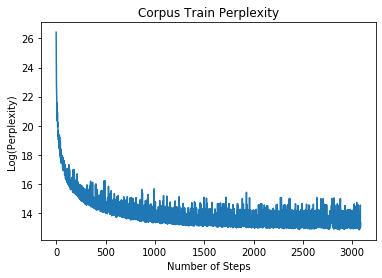

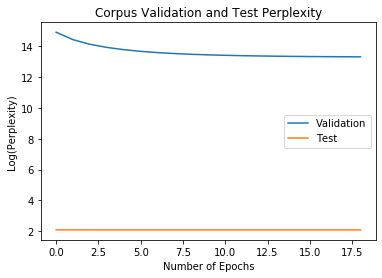

In [84]:
plt.plot(np.log(perplexity_history[1:]))
plt.title('Corpus Train Perplexity')
plt.xlabel('Number of Steps')
plt.ylabel('Log(Perplexity)')
plt.savefig(os.path.join(data_path + "/p2", "run05_train_perplexity"))
plt.show()


plt.plot(np.log(val_perplexity_history[1:]))
plt.plot(np.log(val_cost_history[1:]))
plt.title('Corpus Validation and Test Perplexity')
plt.xlabel('Number of Epochs')
plt.ylabel('Log(Perplexity)')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "run05_test_val_perplexity"))
plt.show()


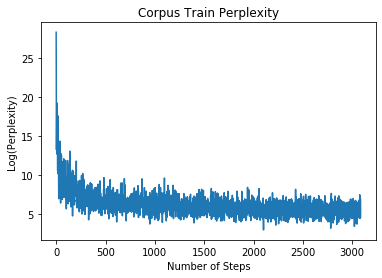

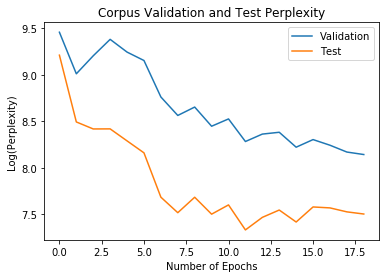

In [87]:
perplexity_history = pickle.load(open(os.path.join(data_path + "/p2",'p2_run03_perplexity_history.p'), "rb"))
cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run03_cost_history.p'), "rb"))
val_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run03_val_perplexity_history.p'), "rb"))
val_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run03_val_cost_history.p'), "rb"))
test_perplexity_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run03_test_perplexity_history.p'), "rb"))
test_cost_history = pickle.load(open(os.path.join(data_path + "/p2", 'p2_run03_test_cost_history.p'), "rb"))

plt.plot(np.log(perplexity_history[1:]))
plt.title('Corpus Train Perplexity')
plt.xlabel('Number of Steps')
plt.ylabel('Log(Perplexity)')
plt.savefig(os.path.join(data_path + "/p2", "run03_train_perplexity"))
plt.show()

plt.plot(np.log(val_perplexity_history[1:]))
plt.plot(np.log(test_perplexity_history[1:]))
plt.title('Corpus Validation and Test Perplexity')
plt.xlabel('Number of Epochs')
plt.ylabel('Log(Perplexity)')
plt.legend(['Validation', 'Test'])
plt.savefig(os.path.join(data_path + "/p2", "run03_test_val_perplexity"))
plt.show()